In [17]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys

import cv2
import numpy as np
from PIL import Image

from matting_api import Matting

sys.path.append('..')
import utils
import inference as infer
from datasets import KINSLVISDataset
from demo_utils import *

font = {'family' : 'sans-serif',
        'size'   : 16}

matplotlib.rc('font', **font)

In [18]:
# functions

def bkg_inpaint(inpaintnet, image, input_size, modal, ex_ind, dilate, bbox=None):
    modal_bkg = (sum([modal[e] for e in ex_ind]) == 0).astype(np.uint8)
    amodal_bkg = np.ones(image.shape[:2], dtype=np.uint8)
    need_recover = False
    if bbox is None:
        need_recover = True
        bbox = get_square_bbox(*image.shape[:2])
    rgb = cv2.resize(
        utils.crop_padding(image, bbox, pad_value=(0,0,0)), (input_size, input_size), interpolation=cv2.INTER_CUBIC)
    modal_patch = infer.resize_mask(
        utils.crop_padding(modal_bkg, bbox, pad_value=(0,)), input_size, 'linear')
    amodal_patch = infer.resize_mask(
        utils.crop_padding(amodal_bkg, bbox, pad_value=(0,)), input_size, 'linear')
    ret, rgb_erased, vsb_mask = inpaintnet.inference(
        rgb, modal_patch, 1, amodal_patch, dilate=dilate, with_modal=False)
    if need_recover:
        ret = recover_image_patch(ret, bbox, image.shape[0], image.shape[1], (255,255,255), interp='cubic')
        vsb_mask = infer.recover_mask(vsb_mask, bbox, image.shape[0], image.shape[1], 'linear')
    return ret, vsb_mask

def content_completion(pcnetc, image, input_size, modal, bboxes, amodal_patches_pred, category, idx, dilate, debug=False):
    rgb = cv2.resize(
        utils.crop_padding(image, bboxes[idx], pad_value=(0,0,0)),
        (input_size, input_size), interpolation=cv2.INTER_CUBIC)
    modal_patch = infer.resize_mask(
       utils.crop_padding(modal[idx], bboxes[idx], pad_value=(0,)), input_size, 'linear')
    amodal_patch = infer.resize_mask(
        amodal_patches_pred[idx], input_size, 'linear')
    ret, rgb_erased, vsb_mask = pcnetc.inference(
        rgb, modal_patch, category[idx].item(), amodal_patch, dilate=dilate)
    ret = recover_image_patch(ret, bboxes[idx], image.shape[0], image.shape[1], (255,255,255))
    vsb_mask = infer.recover_mask(vsb_mask, bboxes[idx], image.shape[0], image.shape[1], 'linear')
    return ret, vsb_mask

In [54]:
# dataset
phase = 'val'
root_dict = {'train': "/ext/hoya/deocclusion/data/KINS/training/image_2", 'val': '/ext/hoya/deocclusion/data/KINS/testing/image_2'}

#img_root = root_dict[phase]
img_root ="/ext/hoya/deocclusion/data/KINS/bmw"
annot_path = "/ext/hoya/deocclusion/data/KINS/instance_bmw.json".format(phase)

data_reader = KINSLVISDataset('KINS', annot_path)

# inmodal_seg(인코딩 모달마스크) 와 inmodal_bbox(bbox)는 있어야한다.

In [32]:
import json

def remove_bbox_and_save(input_file_path, output_file_path):
    # JSON 파일에서 데이터 읽기
    with open(input_file_path, "r") as input_file:
        data = json.load(input_file)

    # "bbox" 키와 해당 값을 제거
    for annotation in data["annotations"]:
        print(annotation)
        del annotation["segmentation"]

    # 수정된 JSON 데이터를 파일에 저장
    with open(output_file_path, "w") as output_file:
        json.dump(data, output_file, indent=4)

    print(f"Modified data saved to {output_file_path}")

# 입력 파일 경로와 출력 파일 경로 지정
input_json_path = "/ext/hoya/deocclusion/data/KINS/instance_test2.json"  # 실제 파일 경로로 수정
output_json_path = "/ext/hoya/deocclusion/data/KINS/instance_test3.json"  # 실제 파일 경로로 수정

# 함수 호출
remove_bbox_and_save(input_json_path, output_json_path)

{'area': 182.0, 'iscrowd': 0, 'inmodal_seg': {'counts': 'eU]93d;0O10000000001O100O105KNeld4', 'size': [375, 1242]}, 'category_id': 7, 'segmentation': [[822, 155, 827, 154, 829, 154, 833, 155, 835, 158, 835, 164, 835, 167, 834, 168, 832, 168, 831, 168, 827, 168, 824, 167, 822, 167]], 'id': 0, 'image_id': 0, 'inmodal_bbox': [822, 154, 13, 14]}
{'area': 408.0, 'iscrowd': 0, 'inmodal_seg': {'counts': '_iX94\\;8K40000000000000000000001O00000000O2N2O1O1N8HPXe4', 'size': [375, 1242]}, 'category_id': 4, 'segmentation': [[812, 158, 823, 158, 826, 158, 828, 158, 831, 160, 833, 163, 833, 168, 834, 171, 833, 172, 831, 173, 829, 173, 828, 175, 826, 175, 823, 175, 822, 174, 813, 174, 812, 174, 810, 173]], 'id': 1, 'image_id': 0, 'inmodal_bbox': [810, 158, 24, 17]}
{'area': 540.0, 'iscrowd': 0, 'inmodal_seg': {'counts': 'Wkf87_;2M2O1O2N2O1O1O1O00001O0000O1O10000000001O001O3M4K2MPSV5', 'size': [375, 1242]}, 'category_id': 4, 'segmentation': [[766, 162, 770, 162, 778, 162, 780, 162, 783, 163, 785, 165,

In [49]:
def points_to_polygon(points):
    """
    Convert point-based segmentation to polygon-based segmentation.

    Parameters:
    - points (list of lists): List of [x, y] points representing the segmentation.

    Returns:
    - list of lists: List of [x, y] points representing the corresponding polygon.
    """
    # Ensure that the list of points is not empty
    if not points:
        return []

    # Duplicate the first point at the end to ensure a closed polygon
    points.append(points[0])

    # Convert the list of points to the polygon format
    polygon = []
    for point in points:
        polygon.append(int(point[0]))
        polygon.append(int(point[1]))

    return polygon

# Example usage:
point_segmentation =[
        [
          1490,
          1434
        ],
        [
          1504,
          1436
        ],
        [
          1511,
          1435
        ],
        [
          1509,
          1429
        ],
        [
          1509,
          1419
        ],
        [
          1516,
          1404
        ],
        [
          1525,
          1396
        ],
        [
          1535,
          1392
        ],
        [
          1526,
          1391
        ],
        [
          1521,
          1392
        ],
        [
          1519,
          1394
        ],
        [
          1504,
          1395
        ],
        [
          1493,
          1407
        ],
        [
          1489,
          1422
        ],
        [
          1489,
          1428
        ]
      ]
polygon_segmentation = points_to_polygon(point_segmentation)
print(polygon_segmentation)

[1490, 1434, 1504, 1436, 1511, 1435, 1509, 1429, 1509, 1419, 1516, 1404, 1525, 1396, 1535, 1392, 1526, 1391, 1521, 1392, 1519, 1394, 1504, 1395, 1493, 1407, 1489, 1422, 1489, 1428, 1490, 1434]


In [50]:
import pycocotools.mask as maskUtils

rles = maskUtils.frPyObjects([polygon_segmentation], 2168, 3840)
print(rles)
rle = maskUtils.merge(rles)
print(rle)

[{'size': [2168, 3840], 'counts': b'TlaR3;YS27J3L4M3O2N1O1O1O1O1O1O2N1N20000000O100_OlmM^OTR2`0QnM]OnQ2b0e0M3N2N2N2N200O00001O1O001O100O10000O101N1000Pl`h4'}]
{'size': [2168, 3840], 'counts': b'TlaR3;YS27J3L4M3O2N1O1O1O1O1O1O2N1N20000000O100_OlmM^OTR2`0QnM]OnQ2b0e0M3N2N2N2N200O00001O1O001O100O10000O101N1000Pl`h4'}


In [13]:
import json

def remove_bbox_and_save(input_file_path, output_file_path):
    # JSON 파일에서 데이터 읽기
    with open(input_file_path, "r") as input_file:
        data = json.load(input_file)

    # "bbox" 키와 해당 값을 제거
    # Filter out annotations with label other than "car"
    filtered_annotations = [annotation for annotation in data["annotations"] if annotation["label"] == "car"]

    # Update the data with filtered annotations
    data["annotations"] = filtered_annotations

    # 수정된 JSON 데이터를 파일에 저장
    with open(output_file_path, "w") as output_file:
        json.dump(data, output_file, indent=4)

    print(f"Modified data saved to {output_file_path}")

# 입력 파일 경로와 출력 파일 경로 지정
input_json_path = "/ext/hoya/deocclusion/data/KINS/instance_aimmo.json"  # 실제 파일 경로로 수정
output_json_path = "/ext/hoya/deocclusion/data/KINS/instance_aimmo2.json"  # 실제 파일 경로로 수정

# 함수 호출
remove_bbox_and_save(input_json_path, output_json_path)

Modified data saved to /ext/hoya/deocclusion/data/KINS/instance_aimmo2.json


In [16]:
def convert_to_xywh(bbox):
    x1, y1, x2, y2 = bbox[0][0], bbox[0][1], bbox[2][0], bbox[2][1]
    x = x1
    y = y1
    w = x2 - x1
    h = y2 - y1
    return [x, y, w, h]

# 예시 좌표
bbox_coordinates = [
        [
          1475,
          1430
        ],
        [
          1522,
          1430
        ],
        [
          1522,
          1384
        ],
        [
          1475,
          1384
        ]
      ]

# 변환된 좌표 출력
converted_coordinates = convert_to_xywh(bbox_coordinates)
print(converted_coordinates)

[1475, 1430, 47, -46]


In [20]:
# PCNet-M
exp = '../experiments/KINS/pcnet_m'

config_file = exp + '/config.yaml'
load_model = '/ext/hoya/deocclusion/kins_model/KINS_pcnet_m.pth.tar'

pcnetm = DemoPCNetM(config_file, load_model)

=> loading checkpoint '/ext/hoya/deocclusion/kins_model/KINS_pcnet_m.pth.tar'


In [ ]:
# PCNet-C
exp = '../experiments/KINS/pcnet_c'

config_file = exp + '/config.yaml'
load_model = '/ext/hoya/deocclusion/kins_model/KINS_pcnet_c.pth.tar'

pcnetc = DemoPCNetC(config_file, load_model)

/deocclusion/demos/demo_utils.py:51: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


=> loading checkpoint '/ext/hoya/deocclusion/kins_model/KINS_pcnet_c.pth.tar'


In [20]:
# background inpainting
exp = '../experiments/KINS/background_inpaint'

config_file = exp + '/config.yaml'
load_model = '/ext/hoya/deocclusion/kins_model/KINS_background_inpaint.pth.tar'

inpaintnet = DemoPCNetC(config_file, load_model)

=> loading checkpoint '/ext/hoya/deocclusion/kins_model/KINS_background_inpaint.pth.tar'


In [24]:
# Matting
# Please download the pretrained model from: https://github.com/Yaoyi-Li/GCA-Matting/blob/master/README.md
matting_model = Matting(
    'GCAMatting/config/gca-dist-all-data.toml',
    'GCAMatting/checkpoints/gca-dist-all-data/gca-dist-all-data.pth')

In [23]:
matting_model

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


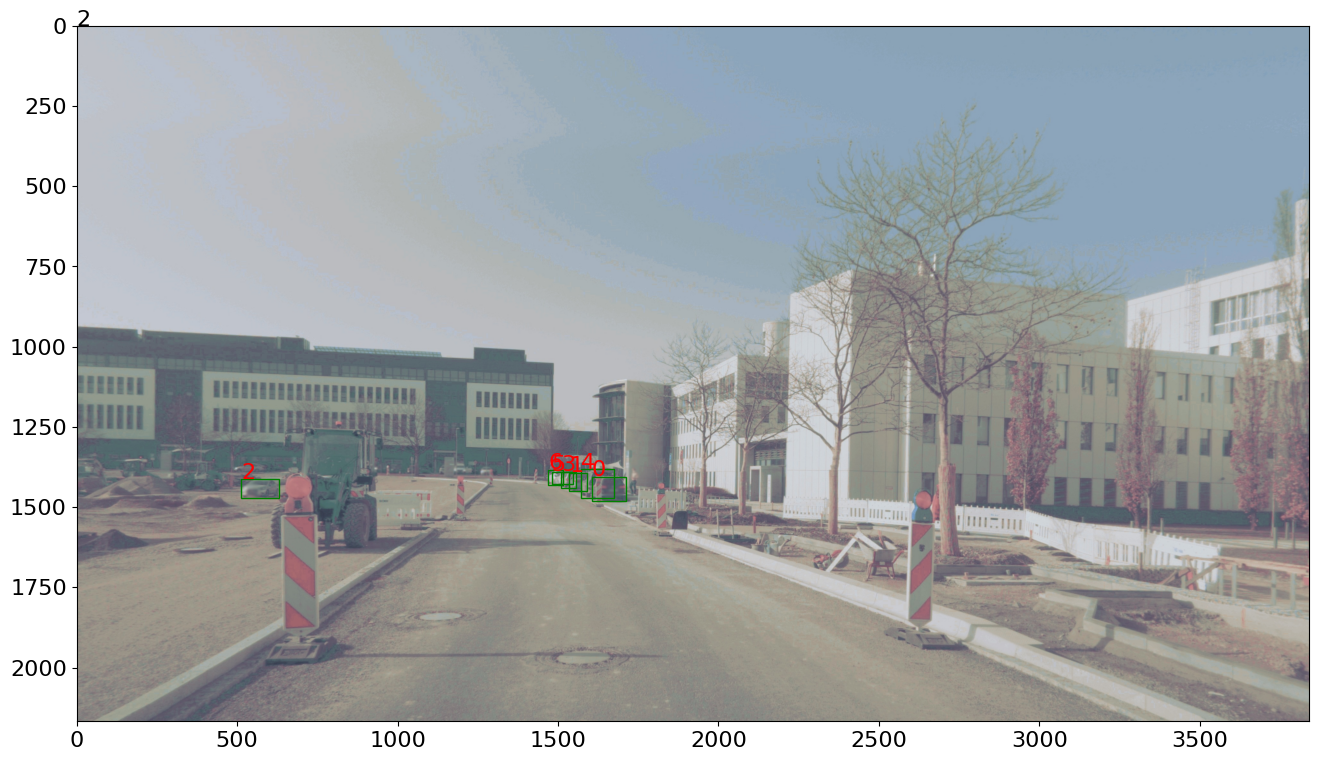

In [55]:
# get an image
img_idx = 2

#img_idx = np.random.choice(len(data_reader.img_ids)) # randomly choose an image
modal, category, ori_bboxes, amodal_gt, image_fn = data_reader.get_image_instances(img_idx, with_gt=False)

img_path = os.path.join(img_root, image_fn)
img = Image.open(img_path)
image = np.array(img)
height, width = img.height, img.width
plt.figure(figsize=(16, 16./width*height))
plt.imshow(img)
plt.text(0, 0, str(img_idx))
ax = plt.gca()
for i, bbox in enumerate(ori_bboxes):
    rect = patches.Rectangle(bbox[:2], bbox[2], bbox[3], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1]-2, str(i), color='r')
plt.show()

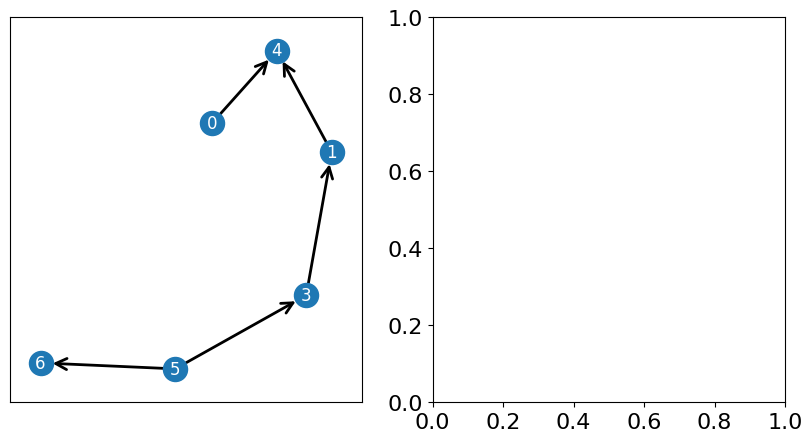

NameError: name 'acc_occpair' is not defined

In [57]:
# infer ordering
#gt_order_matrix = infer.infer_gt_order(modal, amodal_gt)
bboxes = expand_bbox(ori_bboxes, enlarge_ratio=3., single_ratio=1.5)
order_matrix = infer.infer_order(
    pcnetm.model, image, modal, category, bboxes,
    use_rgb=pcnetm.use_rgb, th=0.1, dilate_kernel=0,
    input_size=256, min_input_size=16, interp='nearest', debug_info=False)
#allpair_true, allpair, occpair_true, occpair, show_err = infer.eval_order(order_matrix, gt_order_matrix)
#acc_occpair = occpair_true / occpair
plt.figure(figsize=(10,5))
plt.subplot(121)
pos = draw_graph(order_matrix)
plt.subplot(122)
#draw_graph(gt_order_matrix, pos=pos)
plt.show()
print('left: predicted ordering graph, right: ground truth ordering graph. Accuracy: {:.2f}'.format(acc_occpair * 100))

In [58]:
order_matrix

array([[ 0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0, -1,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0, -1,  0],
       [-1, -1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0, -1,  0]])

[[1622.0, 1482.5, 1619.0, 1482.5, 1607.5, 1470.0, 1606.5, 1436.0, 1617.5, 1420.0, 1623.0, 1414.5, 1636.0, 1406.5, 1692.0, 1406.5, 1699.5, 1413.0, 1710.5, 1435.0, 1713.5, 1454.0, 1713.0, 1480.5, 1701.0, 1481.5, 1690.0, 1474.5, 1648.0, 1473.5, 1638.0, 1475.5, 1628.0, 1481.5, 1622.0, 1482.5]]
[[1551.0, 1452.5, 1541.0, 1450.5, 1535.5, 1445.0, 1533.5, 1439.0, 1532.5, 1415.0, 1539.5, 1401.0, 1546.0, 1394.5, 1592.0, 1394.5, 1592.5, 1396.0, 1572.5, 1420.0, 1572.5, 1448.0, 1571.0, 1444.5, 1554.0, 1444.5, 1551.0, 1452.5]]
[[562.0, 1469.5, 547.0, 1465.5, 533.0, 1465.5, 523.0, 1469.5, 515.0, 1467.5, 511.5, 1464.0, 511.5, 1440.0, 540.0, 1416.5, 547.0, 1413.5, 603.0, 1413.5, 613.0, 1417.5, 624.5, 1431.0, 627.5, 1439.0, 627.5, 1460.0, 622.0, 1465.5, 577.0, 1465.5, 562.0, 1469.5]]
[[1525.0, 1440.5, 1512.0, 1436.5, 1509.5, 1431.0, 1508.5, 1421.0, 1515.5, 1404.0, 1523.0, 1396.5, 1534.0, 1392.5, 1559.0, 1391.5, 1560.0, 1393.5, 1545.0, 1394.5, 1536.5, 1404.0, 1532.5, 1415.0, 1532.5, 1434.0, 1528.0, 1435.5

IndexError: index 0 is out of bounds for axis 0 with size 0

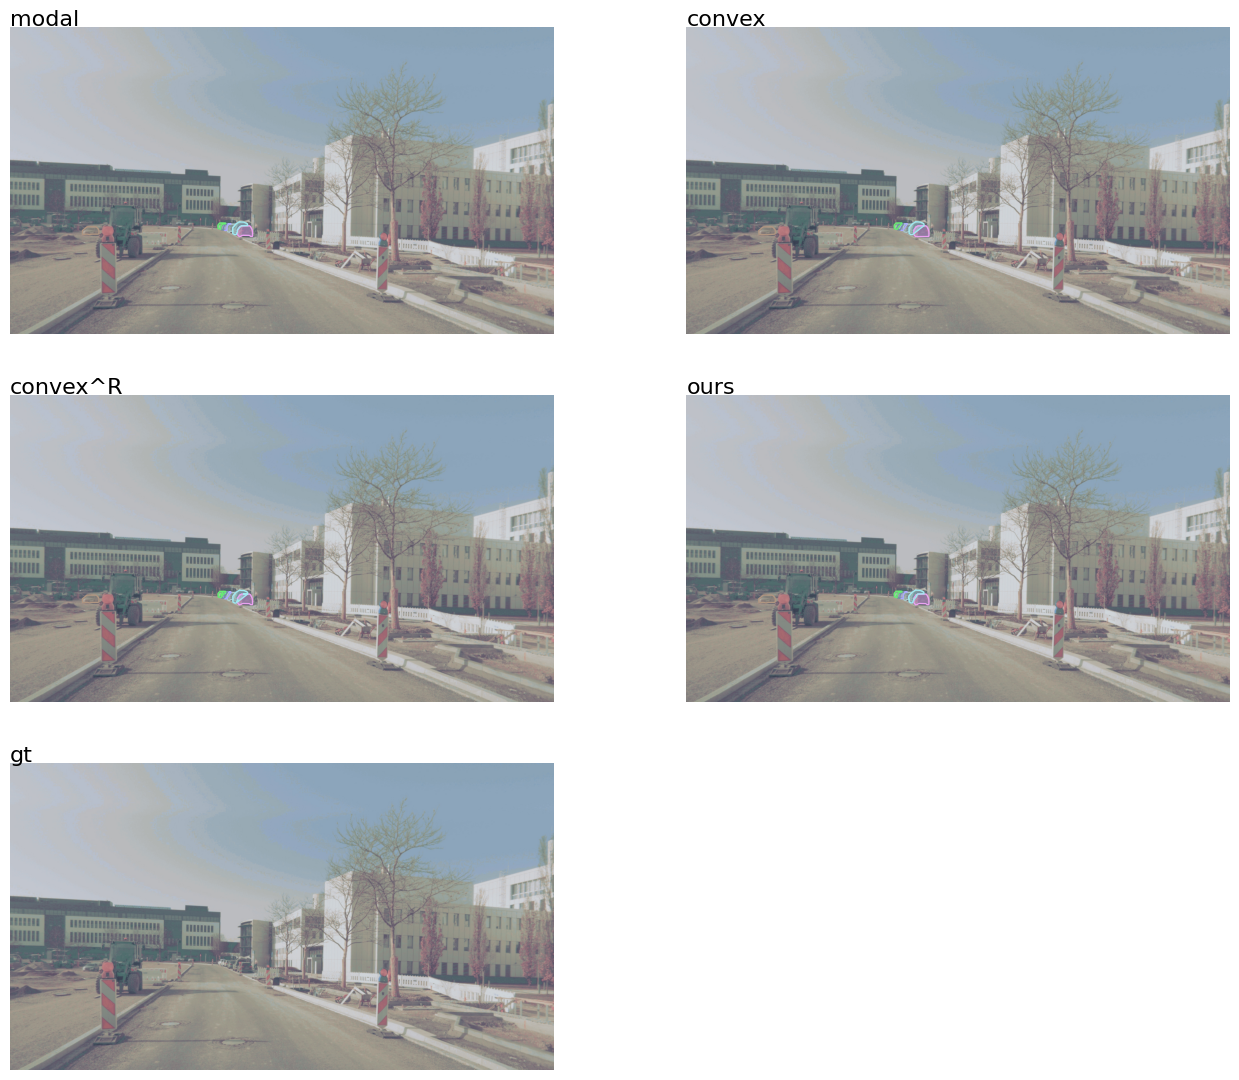

In [59]:
# amodal completion

# convex hull
order_matrix_cvx = infer.infer_order_hull(modal)
amodal_pred_cvx = np.array(infer.infer_amodal_hull(modal, bboxes, None, order_grounded=False))
amodal_pred_cvxr = np.array(infer.infer_amodal_hull(modal, bboxes, order_matrix_cvx, order_grounded=True))

# ours
inmodal_patches, eraser_patches, amodal_patches_pred = infer.infer_amodal(
    pcnetm.model, image, modal, category, bboxes, order_matrix,
    use_rgb=pcnetm.use_rgb, th=0.3, dilate_kernel=0,
    input_size=256, min_input_size=16, interp='linear', order_grounded=True, debug_info=True)
amodal_pred_ours = infer.patch_to_fullimage(
    amodal_patches_pred, bboxes, image.shape[0], image.shape[1], interp='linear')

# show amodal
exclude = []
rows = 3
cols = 2
bbox_show = [0, 0, 500, height]
bbox_show = None

selidx = np.array([i for i in np.arange(modal.shape[0]) if i not in exclude])
image_show = image[bbox_show[1]:bbox_show[3], bbox_show[0]:bbox_show[2], :] \
    if bbox_show is not None else image.copy()

if bbox_show is not None:
    plt.figure(figsize=(16, 16./(bbox_show[2]-bbox_show[0])*(bbox_show[3]-bbox_show[1]) * 3 / 2))
else:
    plt.figure(figsize=(16, 16./width*height * rows / cols))
    
toshow = [modal, amodal_pred_cvx, amodal_pred_cvxr, amodal_pred_ours, amodal_gt]
title = ['modal', 'convex', 'convex^R', 'ours', 'gt']

colors = [(np.random.random((1, 3)) * 0.6 + 0.4).tolist()[0] for i in range(len(selidx))]
for i in range(len(toshow)):
    plt.subplot(rows, cols, i + 1)
    ax = plt.gca()
    plt.imshow(image_show)
    plt.axis('off')
    plt.text(0, -10, title[i])
    pface, pedge = polygon_drawing(toshow[i], selidx, colors, bbox_show, thickness=1)
    ax.add_collection(pface)
    ax.add_collection(pedge)

# plt.savefig('outputs/amodal_display/kins_{}.jpg'.format(img_idx), dpi=72)
# cv2.imwrite("outputs/amodal_display/kins_{}_img.jpg".format(img_idx),
#             image_resize(image_sub[:,:,::-1], long_size=480))
plt.show()

In [65]:
eraser_patches

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0

In [67]:
import cv2
import numpy as np

def resize_image_to_eraser(image, eraser_patch):
    # eraser_patch의 크기를 기준으로 원본 이미지를 리사이징
    resized_image = cv2.resize(image, (eraser_patch.shape[1], eraser_patch.shape[0]),
                                interpolation=cv2.INTER_LINEAR)
    return resized_image

# 예시: 원본 이미지 크기 (1024, 1024)
original_image = np.random.randint(0, 255, size=(1024, 1024, 3), dtype=np.uint8)

# 예시: eraser_patches 중 하나를 기준으로 선택
reference_eraser_patch = eraser_patches[0]

# 이미지를 eraser_patches의 크기에 맞게 리사이징
resized_image = resize_image_to_eraser(original_image, reference_eraser_patch)

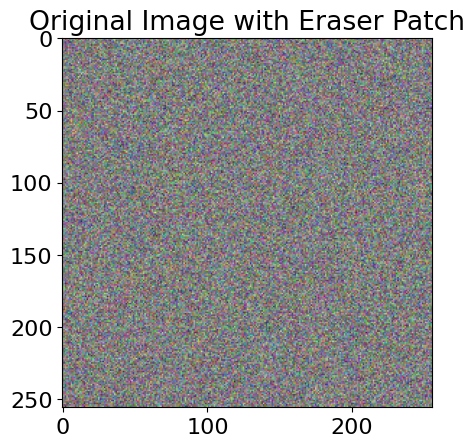

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# 시각화할 이미지 인덱스
idx = 0

# 지워진 영역을 원본 이미지에 표시
masked_image = np.copy(resized_image)  # 복사본 생성
masked_image[eraser_patches[idx] == 1] = [0, 0, 0]  # 검은색으로 표시

plt.imshow(masked_image)
plt.title('Original Image with Eraser Patch')
plt.show()

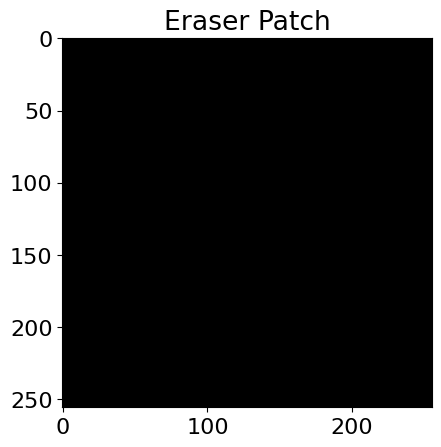

In [69]:
import matplotlib.pyplot as plt

# 시각화할 이미지 인덱스
idx = 0

plt.imshow(eraser_patches[idx], cmap='gray')
plt.title('Eraser Patch')
plt.show()

In [9]:
toshow[3]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [55]:
order_matrix[6][4]

-1

In [60]:
polygons = [[587.0, 1023.5, 0, 1023.5, 0, 528.0, 16.0, 527.5, 18.0, 530.5, 30.0, 530.5, 34.0, 534.5, 46.0, 534.5, 49.0, 538.5, 64.0, 538.5, 67.0, 541.5, 82.0, 541.5, 86.0, 545.5, 98.0, 545.5, 101.0, 549.5, 113.0, 549.5, 116.0, 553.5, 132.0, 553.5, 134.0, 556.5, 149.0, 556.5, 153.0, 560.5, 165.0, 560.5, 168.0, 564.5, 176.0, 564.5, 180.0, 568.5, 192.0, 568.5, 194.0, 571.5, 198.0, 571.5, 202.0, 575.5, 206.0, 575.5, 208.0, 578.5, 214.0, 579.5, 217.0, 583.5, 229.0, 583.5, 231.0, 586.5, 243.0, 586.5, 247.0, 590.5, 255.0, 590.5, 258.0, 594.5, 270.0, 594.5, 272.0, 597.5, 284.0, 597.5, 287.0, 601.5, 299.0, 601.5, 303.0, 605.5, 311.0, 605.5, 314.0, 609.5, 326.0, 609.5, 328.0, 612.5, 336.0, 612.5, 340.0, 616.5, 348.0, 616.5, 351.0, 620.5, 356.0, 620.5, 359.0, 624.5, 363.0, 624.5, 366.0, 627.5, 374.0, 627.5, 377.0, 631.5, 381.0, 631.5, 389.0, 639.5, 393.0, 639.5, 396.0, 642.5, 400.0, 642.5, 407.0, 650.5, 412.0, 650.5, 426.0, 665.5, 430.0, 665.5, 445.0, 680.5, 449.0, 680.5, 460.0, 691.5, 464.0, 691.5, 511.0, 739.5, 523.0, 739.5, 527.0, 743.5, 531.0, 743.5, 540.5, 753.0, 540.5, 761.0, 543.5, 764.0, 543.5, 768.0, 545.0, 769.5, 549.0, 769.5, 553.0, 773.5, 557.0, 773.5, 561.0, 777.5, 565.0, 777.5, 579.0, 792.5, 584.0, 792.5, 598.0, 807.5, 602.0, 807.5, 610.5, 816.0, 610.5, 820.0, 614.5, 823.0, 614.5, 872.0, 618.5, 876.0, 618.5, 925.0, 614.5, 928.0, 614.5, 951.0, 610.5, 955.0, 610.5, 963.0, 607.5, 965.0, 607.5, 973.0, 603.5, 977.0, 603.5, 989.0, 599.5, 992.0, 599.5, 1000.0, 596.5, 1002.0, 596.5, 1014.0, 587.0, 1023.5],
[969.0, 759.5, 965.5, 758.0, 964.0, 754.5, 946.0, 754.5, 939.0, 756.5, 935.5, 753.0, 933.5, 746.0, 934.5, 736.0, 939.5, 724.0, 942.0, 721.5, 967.0, 721.5, 975.5, 731.0, 976.5, 739.0, 975.5, 743.0, 973.5, 744.0, 971.5, 757.0, 969.0, 759.5],
[949.0, 781.5, 942.0, 781.5, 938.5, 779.0, 937.0, 775.5, 930.0, 774.5, 907.0, 773.5, 903.0, 777.5, 899.0, 778.5, 891.0, 777.5, 887.5, 775.0, 885.5, 770.0, 885.5, 751.0, 889.5, 743.0, 901.0, 728.5, 909.0, 726.5, 944.0, 727.5, 948.5, 730.0, 953.0, 741.5, 956.0, 738.5, 960.5, 741.0, 960.5, 745.0, 955.5, 747.0, 957.5, 751.0, 956.5, 775.0, 952.0, 780.5, 949.0, 781.5],
[1208.0, 779.5, 1203.0, 778.5, 1201.0, 772.5, 1197.0, 772.5, 1196.5, 776.0, 1194.0, 778.5, 1187.0, 778.5, 1184.0, 773.5, 1158.0, 772.5, 1154.5, 769.0, 1153.5, 765.0, 1155.5, 753.0, 1157.5, 751.0, 1159.5, 744.0, 1165.0, 738.5, 1171.0, 736.5, 1175.0, 732.5, 1183.0, 732.5, 1187.0, 735.5, 1194.0, 735.5, 1201.0, 738.5, 1211.5, 750.0, 1212.5, 753.0, 1212.5, 769.0, 1210.5, 777.0, 1208.0, 779.5],
[1170.0, 789.5, 1161.0, 788.5, 1158.0, 785.5, 1150.0, 783.5, 1115.0, 783.5, 1114.5, 787.0, 1112.0, 789.5, 1106.0, 789.5, 1100.0, 786.5, 1093.0, 781.5, 1090.5, 777.0, 1090.5, 756.0, 1093.5, 747.0, 1089.5, 744.0, 1089.5, 740.0, 1092.0, 737.5, 1099.0, 737.5, 1104.5, 728.0, 1108.0, 724.5, 1114.0, 722.5, 1140.0, 722.5, 1142.0, 724.5, 1156.0, 724.5, 1160.0, 726.5, 1166.5, 733.0, 1172.5, 746.0, 1172.5, 787.0, 1170.0, 789.5],
[1219.0, 779.5, 1214.5, 775.0, 1215.5, 759.0, 1219.5, 754.0, 1216.5, 753.0, 1215.5, 748.0, 1223.5, 744.0, 1227.5, 734.0, 1230.0, 731.5, 1244.0, 728.5, 1271.0, 728.5, 1275.5, 733.0, 1278.5, 740.0, 1278.5, 749.0, 1277.5, 752.0, 1272.0, 757.5, 1263.0, 762.5, 1260.5, 759.0, 1261.5, 758.0, 1259.0, 750.5, 1257.5, 756.0, 1256.0, 757.5, 1255.0, 756.5, 1253.5, 759.0, 1251.5, 770.0, 1247.0, 771.5, 1245.0, 775.5, 1239.0, 778.5, 1220.0, 777.5, 1219.0, 779.5],
[1080.0, 816.5, 1072.0, 816.5, 1068.5, 813.0, 1068.5, 807.0, 1066.0, 805.5, 1053.0, 801.5, 1044.0, 800.5, 1038.0, 800.5, 1037.5, 804.0, 1035.0, 806.5, 1026.0, 806.5, 1021.0, 800.5, 1005.0, 799.5, 1000.0, 804.5, 991.0, 804.5, 989.5, 810.0, 987.0, 812.5, 980.0, 813.5, 976.5, 811.0, 974.5, 808.0, 974.5, 738.0, 971.5, 735.0, 970.5, 731.0, 973.0, 727.5, 980.5, 727.0, 984.5, 713.0, 988.5, 705.0, 992.0, 701.5, 1065.0, 702.5, 1073.0, 704.5, 1078.5, 710.0, 1082.5, 728.0, 1089.0, 728.5, 1094.5, 733.0, 1094.5, 739.0, 1086.5, 743.0, 1086.5, 812.0, 1080.0, 816.5],
[1425.0, 860.5, 1421.5, 858.0, 1421.0, 855.5, 1416.0, 856.5, 1404.0, 848.5, 1400.0, 848.5, 1388.0, 843.5, 1351.0, 842.5, 1336.0, 842.5, 1332.0, 844.5, 1324.0, 844.5, 1323.0, 846.5, 1303.0, 846.5, 1300.5, 848.0, 1299.5, 852.0, 1294.0, 859.5, 1284.0, 860.5, 1279.0, 859.5, 1271.5, 854.0, 1269.5, 847.0, 1267.5, 846.0, 1265.5, 835.0, 1263.5, 834.0, 1262.0, 829.5, 1255.0, 829.5, 1254.0, 827.5, 1249.0, 826.5, 1235.0, 825.5, 1233.5, 830.0, 1231.5, 831.0, 1230.0, 837.5, 1219.0, 837.5, 1212.5, 833.0, 1208.5, 823.0, 1209.5, 778.0, 1222.5, 766.0, 1220.5, 764.0, 1220.5, 761.0, 1224.0, 756.5, 1229.0, 756.5, 1230.0, 754.5, 1235.0, 761.5, 1237.5, 759.0, 1243.5, 745.0, 1253.0, 735.5, 1270.0, 728.5, 1336.0, 727.5, 1338.0, 724.5, 1341.0, 724.5, 1345.0, 729.5, 1352.0, 729.5, 1353.0, 731.5, 1392.0, 731.5, 1408.5, 757.0, 1412.0, 760.5, 1418.0, 762.5, 1423.5, 768.0, 1423.5, 772.0, 1427.5, 778.0, 1431.5, 794.0, 1435.5, 798.0, 1435.5, 802.0, 1437.5, 803.0, 1439.5, 842.0, 1437.5, 848.0, 1425.0, 860.5],
[1919.0, 1022.5, 1535.0, 1022.5, 1532.0, 1019.5, 1528.0, 1019.5, 1525.0, 1015.5, 1521.0, 1015.5, 1519.0, 1012.5, 1515.0, 1012.5, 1506.0, 1006.5, 1503.0, 1006.5, 1500.0, 1003.5, 1496.0, 1003.5, 1493.0, 999.5, 1486.0, 999.5, 1477.0, 993.5, 1473.0, 993.5, 1471.0, 990.5, 1467.0, 990.5, 1465.0, 987.5, 1461.0, 987.5, 1459.0, 984.5, 1454.0, 983.5, 1445.0, 977.5, 1438.0, 977.5, 1437.5, 982.0, 1433.0, 983.5, 1429.0, 987.5, 1422.0, 987.5, 1420.0, 990.5, 1413.0, 990.5, 1406.0, 983.5, 1403.0, 983.5, 1392.5, 973.0, 1392.5, 970.0, 1389.5, 967.0, 1389.5, 960.0, 1385.5, 957.0, 1385.5, 953.0, 1382.5, 950.0, 1382.5, 940.0, 1379.5, 938.0, 1379.5, 912.0, 1376.5, 909.0, 1376.5, 899.0, 1373.5, 897.0, 1373.5, 890.0, 1369.5, 886.0, 1369.5, 867.0, 1373.5, 864.0, 1373.5, 847.0, 1387.0, 833.5, 1391.0, 833.5, 1394.0, 830.5, 1404.0, 830.5, 1406.0, 827.5, 1410.0, 827.5, 1412.0, 824.5, 1416.0, 824.5, 1420.0, 820.5, 1426.0, 820.5, 1435.0, 811.5, 1439.0, 811.5, 1441.0, 808.5, 1448.0, 808.5, 1452.0, 804.5, 1458.0, 804.5, 1462.0, 808.5, 1467.0, 808.5, 1474.0, 801.5, 1477.0, 801.5, 1486.0, 792.5, 1491.0, 791.5, 1499.0, 782.5, 1503.0, 782.5, 1508.0, 776.5, 1512.0, 776.5, 1516.0, 772.5, 1519.0, 772.5, 1525.0, 766.5, 1528.0, 766.5, 1531.0, 763.5, 1535.0, 763.5, 1537.0, 760.5, 1544.0, 760.5, 1548.0, 756.5, 1554.0, 756.5, 1557.0, 753.5, 1570.0, 753.5, 1573.0, 750.5, 1612.0, 750.5, 1614.0, 747.5, 1647.0, 747.5, 1649.0, 744.5, 1660.0, 744.5, 1663.0, 747.5, 1724.0, 747.5, 1726.0, 750.5, 1775.0, 750.5, 1777.0, 753.5, 1826.0, 753.5, 1828.0, 756.5, 1870.0, 756.5, 1874.0, 760.5, 1919.0, 760.5, 1919.0, 1022.5],
[850.0, 757.5, 848.0, 757.5, 845.0, 753.5, 843.0, 753.5, 841.0, 757.5, 837.0, 757.5, 834.0, 753.5, 820.0, 753.5, 819.5, 756.0, 817.0, 757.5, 813.0, 753.5, 810.0, 753.5, 808.0, 756.5, 805.0, 757.5, 801.5, 754.0, 801.5, 739.0, 806.5, 730.0, 813.0, 724.5, 840.0, 724.5, 851.5, 735.0, 848.5, 739.0, 851.5, 747.0, 851.5, 756.0, 850.0, 757.5],
[802.0, 743.5, 799.0, 743.5, 797.0, 741.5, 792.0, 741.5, 788.0, 743.5, 784.5, 740.0, 783.5, 731.0, 789.0, 725.5, 792.0, 724.5, 807.0, 725.5, 812.5, 732.0, 812.5, 738.0, 810.0, 741.5, 809.0, 740.5, 802.0, 743.5]]

polygons =[[3646.0, 990.5, 3586.0, 990.5, 3583.0, 987.5, 3580.0, 987.5, 3577.0, 984.5, 3572.0, 983.5, 3564.0, 974.5, 3560.0, 974.5, 3548.0, 961.5, 3535.0, 961.5, 3532.0, 958.5, 3522.0, 958.5, 3520.0, 955.5, 3513.0, 955.5, 3510.0, 952.5, 3500.0, 952.5, 3498.0, 949.5, 3488.0, 949.5, 3485.0, 946.5, 3476.0, 946.5, 3472.0, 942.5, 3462.0, 942.5, 3459.0, 939.5, 3403.0, 939.5, 3396.0, 946.5, 3387.0, 949.5, 3381.0, 955.5, 3365.0, 955.5, 3362.0, 958.5, 3355.0, 958.5, 3352.0, 955.5, 3342.0, 955.5, 3337.0, 949.5, 3333.0, 949.5, 3327.0, 942.5, 3323.0, 942.5, 3300.5, 920.0, 3300.5, 853.0, 3312.5, 841.0, 3312.5, 837.0, 3326.0, 823.5, 3330.0, 823.5, 3337.0, 816.5, 3340.0, 816.5, 3346.0, 810.5, 3349.0, 810.5, 3352.0, 807.5, 3359.0, 807.5, 3361.0, 804.5, 3365.0, 804.5, 3369.0, 800.5, 3385.0, 800.5, 3387.0, 797.5, 3397.0, 797.5, 3400.0, 794.5, 3646.0, 794.5, 3648.0, 797.5, 3684.0, 797.5, 3686.0, 800.5, 3712.0, 800.5, 3716.0, 804.5, 3722.0, 804.5, 3725.0, 807.5, 3732.0, 807.5, 3734.0, 810.5, 3741.0, 810.5, 3743.0, 813.5, 3747.0, 813.5, 3749.0, 816.5, 3753.0, 816.5, 3769.0, 826.5, 3773.0, 826.5, 3775.0, 829.5, 3779.0, 829.5, 3784.0, 835.5, 3788.0, 835.5, 3790.0, 838.5, 3794.0, 838.5, 3798.0, 842.5, 3801.0, 842.5, 3810.0, 848.5, 3814.0, 848.5, 3819.0, 854.5, 3823.0, 854.5, 3825.0, 857.5, 3829.0, 857.5, 3831.0, 860.5, 3835.0, 860.5, 3836.5, 862.0, 3836.5, 866.0, 3839.5, 868.0, 3839.5, 967.0, 3832.0, 974.5, 3794.0, 974.5, 3791.0, 971.5, 3759.0, 971.5, 3757.0, 968.5, 3683.0, 968.5, 3681.0, 971.5, 3674.0, 971.5, 3671.0, 974.5, 3668.0, 974.5, 3662.0, 980.5, 3659.0, 980.5, 3652.0, 987.5, 3648.0, 987.5, 3646.0, 990.5]
,[2510.0, 874.5, 2503.0, 874.5, 2497.5, 870.0, 2497.5, 867.0, 2492.0, 862.5, 2481.0, 861.5, 2470.0, 861.5, 2463.0, 864.5, 2452.0, 864.5, 2446.0, 861.5, 2437.0, 861.5, 2425.0, 871.5, 2416.0, 872.5, 2407.0, 869.5, 2391.0, 853.5, 2383.0, 851.5, 2366.0, 852.5, 2363.5, 850.0, 2363.5, 847.0, 2361.0, 845.5, 2356.0, 844.5, 2352.0, 841.5, 2340.0, 840.5, 2329.5, 832.0, 2325.5, 821.0, 2324.5, 795.0, 2327.5, 782.0, 2330.5, 780.0, 2334.5, 773.0, 2343.5, 765.0, 2343.5, 761.0, 2347.0, 757.5, 2367.0, 744.5, 2470.0, 744.5, 2471.0, 746.5, 2477.0, 747.5, 2489.5, 760.0, 2502.5, 777.0, 2512.5, 794.0, 2515.5, 802.0, 2517.5, 803.0, 2517.5, 807.0, 2524.5, 822.0, 2524.5, 866.0, 2518.0, 873.5, 2510.0, 874.5]
,[2634.0, 870.5, 2617.0, 870.5, 2611.0, 863.5, 2568.0, 862.5, 2556.0, 869.5, 2539.0, 865.5, 2534.0, 862.5, 2525.5, 853.0, 2527.5, 841.0, 2525.5, 825.0, 2504.0, 804.5, 2493.0, 797.5, 2484.5, 787.0, 2484.5, 784.0, 2489.0, 778.5, 2494.0, 775.5, 2501.0, 775.5, 2503.0, 773.5, 2526.0, 773.5, 2550.0, 774.5, 2597.0, 784.5, 2623.0, 803.5, 2634.0, 807.5, 2640.0, 811.5, 2644.5, 816.0, 2649.5, 826.0, 2649.5, 841.0, 2646.5, 845.0, 2648.5, 850.0, 2647.5, 858.0, 2641.0, 861.5, 2634.0, 870.5]
,[3224.0, 871.5, 3218.0, 871.5, 3217.0, 869.5, 3212.0, 868.5, 3211.0, 866.5, 3206.0, 866.5, 3198.0, 862.5, 3163.0, 861.5, 3158.0, 864.5, 3146.0, 866.5, 3141.0, 869.5, 3135.0, 866.5, 3125.0, 864.5, 3114.5, 853.0, 3114.5, 827.0, 3122.0, 818.5, 3136.0, 818.5, 3144.0, 817.5, 3146.0, 815.5, 3158.0, 815.5, 3168.0, 810.5, 3171.0, 810.5, 3178.0, 805.5, 3186.0, 804.5, 3188.0, 802.5, 3196.0, 801.5, 3198.0, 799.5, 3206.0, 799.5, 3211.0, 797.5, 3225.0, 797.5, 3227.0, 795.5, 3238.0, 794.5, 3318.0, 794.5, 3324.0, 797.5, 3335.0, 798.5, 3339.0, 799.5, 3342.0, 802.5, 3345.0, 802.5, 3354.0, 810.5, 3371.0, 817.5, 3380.0, 826.5, 3382.0, 826.5, 3383.5, 830.0, 3382.5, 838.0, 3379.5, 838.0, 3379.5, 846.0, 3377.0, 849.5, 3373.5, 850.0, 3373.5, 852.0, 3368.0, 858.5, 3357.0, 859.5, 3355.0, 861.5, 3348.0, 862.5, 3301.0, 862.5, 3300.0, 864.5, 3255.0, 866.5, 3253.0, 868.5, 3226.0, 869.5, 3224.0, 871.5]
,[2791.0, 872.5, 2768.0, 872.5, 2758.0, 865.5, 2741.0, 864.5, 2726.0, 864.5, 2715.0, 872.5, 2701.0, 872.5, 2693.0, 869.5, 2683.0, 857.5, 2668.0, 857.5, 2667.0, 855.5, 2653.0, 857.5, 2651.5, 856.0, 2651.5, 831.0, 2650.5, 828.0, 2648.5, 827.0, 2648.5, 822.0, 2644.5, 815.0, 2633.0, 804.5, 2613.0, 794.5, 2598.5, 780.0, 2598.5, 776.0, 2616.0, 775.5, 2618.0, 773.5, 2723.0, 773.5, 2725.0, 775.5, 2739.0, 776.5, 2749.0, 783.5, 2752.0, 787.5, 2754.0, 787.5, 2768.0, 798.5, 2770.0, 798.5, 2771.0, 801.5, 2773.0, 801.5, 2782.0, 808.5, 2792.0, 812.5, 2806.5, 827.0, 2806.5, 861.0, 2805.0, 863.5, 2803.0, 863.5, 2791.0, 872.5]
,[2360.0, 871.5, 2347.0, 871.5, 2336.0, 861.5, 2326.0, 860.5, 2324.0, 858.5, 2317.0, 858.5, 2315.0, 860.5, 2304.0, 861.5, 2285.0, 860.5, 2283.0, 858.5, 2280.0, 858.5, 2267.0, 869.5, 2259.0, 870.5, 2252.5, 866.0, 2249.5, 858.0, 2244.0, 852.5, 2242.0, 852.5, 2237.0, 846.5, 2220.0, 833.5, 2194.0, 832.5, 2179.5, 819.0, 2178.5, 815.0, 2179.5, 763.0, 2201.0, 746.5, 2219.0, 740.5, 2284.0, 738.5, 2322.0, 741.5, 2328.0, 743.5, 2345.5, 769.0, 2359.5, 798.0, 2359.5, 805.0, 2363.5, 821.0, 2362.5, 869.0, 2360.0, 871.5]]

polygons = [[2620.0, 1821.5, 2578.0, 1821.5, 2571.0, 1813.5, 2566.0, 1813.5, 2551.5, 1799.0, 2551.5, 1790.0, 2547.5, 1787.0, 2547.5, 1769.0, 2543.5, 1766.0, 2543.5, 1732.0, 2538.5, 1727.0, 2538.5, 1719.0, 2534.5, 1715.0, 2534.5, 1711.0, 2520.0, 1696.5, 2516.0, 1696.5, 2512.0, 1692.5, 2503.0, 1692.5, 2500.0, 1688.5, 2478.0, 1688.5, 2475.0, 1692.5, 2470.0, 1692.5, 2459.5, 1703.0, 2459.5, 1708.0, 2450.0, 1717.5, 2441.0, 1717.5, 2438.0, 1721.5, 2416.0, 1721.5, 2412.0, 1717.5, 2408.0, 1717.5, 2397.5, 1707.0, 2397.5, 1515.0, 2405.5, 1508.0, 2405.5, 1503.0, 2418.5, 1491.0, 2418.5, 1482.0, 2437.0, 1463.5, 2442.0, 1463.5, 2445.0, 1459.5, 2450.0, 1459.5, 2472.5, 1437.0, 2472.5, 1432.0, 2512.0, 1392.5, 2517.0, 1392.5, 2536.0, 1372.5, 2541.0, 1372.5, 2544.0, 1368.5, 2550.0, 1367.5, 2558.0, 1359.5, 2562.0, 1359.5, 2566.0, 1355.5, 2571.0, 1355.5, 2574.0, 1351.5, 2587.0, 1351.5, 2590.0, 1347.5, 2787.0, 1347.5, 2791.0, 1351.5, 2895.0, 1351.5, 2899.0, 1355.5, 2916.0, 1355.5, 2919.0, 1359.5, 2928.0, 1359.5, 2931.0, 1363.5, 2936.0, 1363.5, 2945.0, 1372.5, 2949.0, 1372.5, 2975.5, 1399.0, 2975.5, 1403.0, 2982.0, 1409.5, 2986.0, 1409.5, 2992.5, 1416.0, 2992.5, 1420.0, 2995.0, 1422.5, 2999.0, 1422.5, 3040.0, 1463.5, 3045.0, 1463.5, 3057.0, 1476.5, 3062.0, 1476.5, 3075.5, 1490.0, 3075.5, 1495.0, 3083.5, 1502.0, 3083.5, 1507.0, 3088.5, 1512.0, 3088.5, 1516.0, 3092.5, 1520.0, 3092.5, 1529.0, 3096.5, 1532.0, 3096.5, 1645.0, 3070.0, 1671.5, 3064.0, 1672.5, 3059.5, 1677.0, 3059.5, 1682.0, 3057.0, 1684.5, 3052.0, 1684.5, 3050.5, 1686.0, 3050.5, 1753.0, 3046.5, 1757.0, 3046.5, 1761.0, 3015.0, 1792.5, 3002.0, 1792.5, 2999.0, 1796.5, 2994.0, 1796.5, 2991.0, 1792.5, 2982.0, 1792.5, 2979.0, 1788.5, 2974.0, 1788.5, 2970.0, 1784.5, 2945.0, 1784.5, 2938.5, 1778.0, 2938.5, 1765.0, 2937.0, 1763.5, 2886.0, 1763.5, 2883.0, 1759.5, 2682.0, 1759.5, 2678.0, 1763.5, 2661.0, 1763.5, 2658.0, 1767.5, 2653.0, 1767.5, 2651.5, 1769.0, 2651.5, 1774.0, 2647.5, 1777.0, 2647.5, 1782.0, 2642.5, 1787.0, 2642.5, 1795.0, 2638.5, 1799.0, 2638.5, 1803.0, 2620.0, 1821.5]
,[2285.0, 1644.5, 2271.0, 1644.5, 2258.5, 1632.0, 2256.5, 1624.0, 2254.5, 1622.0, 2254.5, 1615.0, 2252.5, 1614.0, 2252.5, 1605.0, 2248.5, 1597.0, 2243.0, 1591.5, 2236.0, 1589.5, 2235.0, 1591.5, 2232.0, 1591.5, 2229.0, 1595.5, 2224.0, 1597.5, 2215.0, 1604.5, 2212.0, 1604.5, 2203.0, 1597.5, 2199.5, 1597.0, 2199.5, 1544.0, 2197.5, 1542.0, 2197.5, 1485.0, 2199.5, 1483.0, 2199.5, 1479.0, 2201.5, 1477.0, 2201.5, 1472.0, 2203.5, 1471.0, 2203.5, 1468.0, 2206.5, 1466.0, 2208.5, 1459.0, 2216.5, 1449.0, 2216.5, 1438.0, 2210.5, 1433.0, 2210.5, 1421.0, 2214.0, 1420.5, 2215.0, 1418.5, 2228.0, 1418.5, 2230.0, 1420.5, 2235.0, 1420.5, 2236.0, 1418.5, 2243.0, 1418.5, 2256.5, 1405.0, 2260.5, 1395.0, 2267.5, 1386.0, 2267.5, 1383.0, 2269.5, 1382.0, 2271.5, 1375.0, 2277.5, 1369.0, 2277.5, 1367.0, 2283.0, 1361.5, 2287.0, 1359.5, 2294.0, 1359.5, 2295.0, 1357.5, 2317.0, 1357.5, 2319.0, 1355.5, 2374.0, 1355.5, 2375.0, 1353.5, 2406.0, 1353.5, 2408.0, 1355.5, 2473.0, 1355.5, 2475.0, 1357.5, 2503.0, 1357.5, 2504.0, 1359.5, 2517.0, 1359.5, 2519.0, 1361.5, 2526.0, 1361.5, 2527.0, 1363.5, 2530.0, 1363.5, 2537.5, 1371.0, 2537.5, 1376.0, 2541.0, 1376.5, 2552.5, 1388.0, 2554.5, 1393.0, 2560.5, 1398.0, 2560.5, 1403.0, 2563.0, 1405.5, 2566.0, 1403.5, 2566.5, 1407.0, 2568.5, 1408.0, 2568.5, 1413.0, 2570.5, 1415.0, 2570.5, 1423.0, 2573.5, 1426.0, 2573.5, 1454.0, 2575.5, 1456.0, 2575.5, 1485.0, 2570.5, 1494.0, 2566.0, 1494.5, 2562.5, 1485.0, 2557.0, 1481.5, 2553.0, 1481.5, 2551.0, 1475.5, 2543.0, 1471.5, 2532.0, 1471.5, 2530.0, 1473.5, 2527.0, 1473.5, 2526.0, 1475.5, 2517.0, 1475.5, 2515.0, 1477.5, 2507.0, 1477.5, 2505.0, 1479.5, 2502.0, 1479.5, 2490.5, 1491.0, 2490.0, 1494.5, 2487.0, 1494.5, 2486.0, 1496.5, 2479.0, 1496.5, 2471.0, 1502.5, 2456.0, 1502.5, 2454.0, 1504.5, 2446.0, 1504.5, 2443.0, 1507.5, 2428.0, 1507.5, 2426.0, 1511.5, 2419.0, 1514.5, 2417.5, 1518.0, 2409.0, 1526.5, 2403.0, 1528.5, 2401.0, 1532.5, 2397.0, 1532.5, 2395.5, 1534.0, 2395.5, 1538.0, 2393.5, 1540.0, 2393.5, 1549.0, 2391.5, 1550.0, 2391.5, 1557.0, 2389.5, 1559.0, 2389.5, 1565.0, 2387.5, 1567.0, 2387.5, 1595.0, 2385.5, 1596.0, 2385.5, 1601.0, 2378.0, 1608.5, 2374.0, 1610.5, 2348.0, 1610.5, 2347.0, 1612.5, 2323.0, 1612.5, 2315.5, 1620.0, 2315.5, 1625.0, 2311.5, 1630.0, 2311.5, 1635.0, 2304.0, 1642.5, 2287.0, 1642.5, 2285.0, 1644.5]
,[1491.0, 1702.5, 1470.0, 1702.5, 1469.0, 1700.5, 1451.0, 1700.5, 1449.5, 1696.0, 1446.5, 1694.0, 1446.5, 1691.0, 1439.5, 1684.0, 1439.5, 1681.0, 1426.0, 1667.5, 1420.0, 1667.5, 1418.0, 1664.5, 1238.0, 1664.5, 1235.0, 1667.5, 1222.0, 1667.5, 1221.0, 1669.5, 1215.0, 1669.5, 1212.0, 1672.5, 1207.0, 1672.5, 1198.5, 1681.0, 1198.5, 1684.0, 1193.5, 1688.0, 1193.5, 1691.0, 1187.0, 1697.5, 1172.0, 1697.5, 1169.0, 1694.5, 1164.0, 1694.5, 1158.5, 1689.0, 1158.5, 1686.0, 1155.5, 1684.0, 1155.5, 1681.0, 1150.5, 1676.0, 1150.5, 1671.0, 1145.5, 1666.0, 1145.5, 1661.0, 1140.5, 1656.0, 1140.5, 1651.0, 1135.5, 1646.0, 1135.5, 1628.0, 1132.5, 1625.0, 1132.5, 1537.0, 1150.5, 1519.0, 1150.5, 1516.0, 1160.5, 1507.0, 1160.5, 1504.0, 1175.5, 1489.0, 1175.5, 1486.0, 1184.0, 1477.5, 1193.0, 1474.5, 1197.0, 1469.5, 1205.0, 1467.5, 1207.0, 1464.5, 1210.0, 1464.5, 1215.0, 1459.5, 1218.0, 1459.5, 1226.5, 1451.0, 1226.5, 1448.0, 1236.5, 1438.0, 1236.5, 1435.0, 1244.5, 1428.0, 1244.5, 1425.0, 1254.5, 1415.0, 1254.5, 1412.0, 1260.0, 1406.5, 1263.0, 1406.5, 1271.0, 1398.5, 1274.0, 1398.5, 1275.0, 1396.5, 1278.0, 1396.5, 1281.0, 1393.5, 1293.0, 1391.5, 1296.0, 1388.5, 1322.0, 1388.5, 1323.0, 1386.5, 1494.0, 1386.5, 1499.0, 1391.5, 1502.0, 1391.5, 1503.0, 1393.5, 1512.0, 1396.5, 1540.5, 1425.0, 1540.5, 1431.0, 1542.5, 1432.0, 1542.5, 1435.0, 1545.5, 1438.0, 1545.5, 1446.0, 1550.5, 1453.0, 1550.5, 1456.0, 1555.5, 1463.0, 1555.5, 1466.0, 1560.5, 1471.0, 1560.5, 1474.0, 1563.5, 1476.0, 1563.5, 1499.0, 1565.5, 1501.0, 1565.5, 1638.0, 1549.0, 1654.5, 1546.0, 1654.5, 1540.5, 1649.0, 1540.5, 1643.0, 1537.5, 1640.0, 1537.5, 1635.0, 1535.5, 1633.0, 1535.5, 1630.0, 1532.5, 1628.0, 1532.5, 1625.0, 1529.0, 1624.5, 1522.0, 1616.5, 1513.0, 1619.5, 1502.5, 1630.0, 1502.5, 1633.0, 1499.5, 1636.0, 1499.5, 1643.0, 1502.5, 1646.0, 1502.5, 1656.0, 1507.5, 1663.0, 1507.5, 1679.0, 1504.5, 1681.0, 1502.5, 1691.0, 1491.0, 1702.5]
,[1791.0, 1511.5, 1779.0, 1511.5, 1775.5, 1507.0, 1774.5, 1499.0, 1770.0, 1494.5, 1709.0, 1494.5, 1691.0, 1499.5, 1684.0, 1507.5, 1676.0, 1509.5, 1670.5, 1503.0, 1667.5, 1494.0, 1667.5, 1452.0, 1673.5, 1436.0, 1697.0, 1410.5, 1704.0, 1407.5, 1773.0, 1407.5, 1796.5, 1437.0, 1796.5, 1506.0, 1791.0, 1511.5]
,[2203.0, 1574.5, 2185.0, 1574.5, 2180.0, 1569.5, 2172.0, 1567.5, 2170.0, 1565.5, 2165.0, 1565.5, 2152.5, 1553.0, 2151.5, 1537.0, 2149.5, 1536.0, 2148.5, 1514.0, 2149.5, 1481.0, 2153.5, 1477.0, 2154.5, 1473.0, 2163.5, 1459.0, 2161.5, 1452.0, 2161.5, 1446.0, 2163.0, 1444.5, 2174.0, 1444.5, 2179.0, 1442.5, 2184.5, 1436.0, 2184.5, 1434.0, 2188.5, 1431.0, 2192.5, 1423.0, 2206.5, 1409.0, 2207.0, 1406.5, 2217.0, 1404.5, 2219.0, 1402.5, 2230.0, 1402.5, 2231.0, 1404.5, 2237.0, 1406.5, 2239.5, 1409.0, 2239.5, 1417.0, 2236.5, 1421.0, 2235.5, 1438.0, 2231.5, 1446.0, 2229.5, 1474.0, 2211.5, 1500.0, 2206.5, 1510.0, 2196.5, 1517.0, 2196.5, 1554.0, 2198.5, 1556.0, 2198.5, 1562.0, 2204.5, 1566.0, 2204.5, 1573.0, 2203.0, 1574.5]
,[1989.0, 1493.5, 1987.0, 1493.5, 1982.5, 1489.0, 1980.5, 1484.0, 1978.5, 1429.0, 1985.5, 1412.0, 2000.0, 1396.5, 2008.0, 1394.5, 2014.0, 1399.5, 2018.0, 1399.5, 2021.5, 1396.0, 2022.0, 1392.5, 2026.0, 1392.5, 2028.5, 1402.0, 2038.5, 1411.0, 2033.5, 1418.0, 2036.0, 1420.5, 2041.5, 1419.0, 2042.5, 1417.0, 2039.5, 1414.0, 2045.0, 1408.5, 2050.0, 1408.5, 2056.0, 1413.5, 2071.5, 1417.0, 2076.5, 1424.0, 2080.5, 1436.0, 2080.5, 1474.0, 2076.5, 1484.0, 2071.0, 1489.5, 2069.0, 1490.5, 2061.0, 1481.5, 2055.0, 1479.5, 2009.0, 1479.5, 2000.0, 1481.5, 1994.5, 1490.0, 1989.0, 1493.5]
,[3642.0, 2159.5, 3323.0, 2159.5, 3318.0, 2153.5, 3299.0, 2153.5, 3294.0, 2147.5, 3282.0, 2147.5, 3276.0, 2141.5, 3264.0, 2141.5, 3258.0, 2135.5, 3246.0, 2135.5, 3241.0, 2129.5, 3222.0, 2129.5, 3217.0, 2123.5, 3204.0, 2123.5, 3199.0, 2117.5, 3186.0, 2117.5, 3181.0, 2111.5, 3163.0, 2111.5, 3159.0, 2106.5, 3146.0, 2106.5, 3141.0, 2100.5, 3128.0, 2100.5, 3123.0, 2094.5, 3093.0, 2094.5, 3088.0, 2088.5, 3063.0, 2088.5, 3058.0, 2082.5, 3034.0, 2082.5, 3028.0, 2076.5, 3010.0, 2076.5, 3004.0, 2070.5, 2992.0, 2070.5, 2977.5, 2056.0, 2977.5, 2049.0, 2960.5, 2033.0, 2960.5, 2003.0, 2954.5, 1998.0, 2954.5, 1962.0, 2948.5, 1956.0, 2948.5, 1920.0, 2942.5, 1915.0, 2942.5, 1879.0, 2936.5, 1873.0, 2936.5, 1837.0, 2930.5, 1831.0, 2936.5, 1826.0, 2936.5, 1813.0, 2942.5, 1808.0, 2942.5, 1796.0, 2948.5, 1790.0, 2948.5, 1778.0, 2954.5, 1772.0, 2954.5, 1760.0, 2959.5, 1756.0, 2960.5, 1748.0, 3007.5, 1702.0, 3007.5, 1695.0, 3010.0, 1692.5, 3023.0, 1692.5, 3028.0, 1686.5, 3041.0, 1686.5, 3045.0, 1681.5, 3063.0, 1681.5, 3068.0, 1675.5, 3087.0, 1675.5, 3092.0, 1669.5, 3111.0, 1669.5, 3116.0, 1663.5, 3134.0, 1663.5, 3140.0, 1657.5, 3158.0, 1657.5, 3163.0, 1651.5, 3176.0, 1651.5, 3181.0, 1645.5, 3200.0, 1645.5, 3205.0, 1639.5, 3217.0, 1639.5, 3223.0, 1633.5, 3229.0, 1633.5, 3233.0, 1628.5, 3241.0, 1627.5, 3245.0, 1622.5, 3252.0, 1622.5, 3257.0, 1616.5, 3264.0, 1616.5, 3269.0, 1610.5, 3282.0, 1610.5, 3287.0, 1604.5, 3294.0, 1604.5, 3299.0, 1598.5, 3306.0, 1598.5, 3311.0, 1592.5, 3318.0, 1592.5, 3323.0, 1586.5, 3329.0, 1586.5, 3335.0, 1580.5, 3341.0, 1580.5, 3347.0, 1574.5, 3359.0, 1574.5, 3363.0, 1569.5, 3371.0, 1568.5, 3375.0, 1563.5, 3382.0, 1563.5, 3387.0, 1557.5, 3394.0, 1557.5, 3399.0, 1551.5, 3406.0, 1551.5, 3411.0, 1545.5, 3418.0, 1545.5, 3423.0, 1539.5, 3435.0, 1539.5, 3441.0, 1533.5, 3447.0, 1533.5, 3451.0, 1528.5, 3459.0, 1527.5, 3469.0, 1516.5, 3477.0, 1515.5, 3493.0, 1498.5, 3500.0, 1498.5, 3511.0, 1486.5, 3518.0, 1486.5, 3529.0, 1474.5, 3536.0, 1474.5, 3553.0, 1456.5, 3560.0, 1456.5, 3571.0, 1444.5, 3578.0, 1444.5, 3588.0, 1433.5, 3596.0, 1432.5, 3612.0, 1415.5, 3618.0, 1415.5, 3624.0, 1409.5, 3636.0, 1409.5, 3642.0, 1403.5, 3654.0, 1403.5, 3660.0, 1397.5, 3672.0, 1397.5, 3677.0, 1391.5, 3690.0, 1391.5, 3695.0, 1385.5, 3702.0, 1385.5, 3706.0, 1380.5, 3718.0, 1380.5, 3724.0, 1374.5, 3736.0, 1374.5, 3741.0, 1368.5, 3754.0, 1368.5, 3759.0, 1362.5, 3772.0, 1362.5, 3777.0, 1356.5, 3790.0, 1356.5, 3795.0, 1350.5, 3802.0, 1350.5, 3807.0, 1344.5, 3819.0, 1344.5, 3821.5, 1347.0, 3822.5, 1355.0, 3827.5, 1359.0, 3827.5, 1377.0, 3833.5, 1383.0, 3833.5, 1401.0, 3839.5, 1406.0, 3839.5, 2151.0, 3837.0, 2153.5, 3647.0, 2153.5, 3642.0, 2159.5]
,[1819.0, 1468.5, 1788.0, 1467.5, 1784.5, 1462.0, 1785.5, 1457.0, 1782.5, 1452.0, 1784.5, 1447.0, 1785.5, 1435.0, 1788.5, 1428.0, 1785.5, 1421.0, 1790.0, 1413.5, 1816.0, 1418.5, 1832.0, 1418.5, 1833.5, 1420.0, 1840.5, 1434.0, 1840.5, 1454.0, 1838.5, 1464.0, 1837.0, 1467.5, 1819.0, 1468.5]]

polygons = [[1622.0, 1482.5, 1619.0, 1482.5, 1607.5, 1470.0, 1606.5, 1436.0, 1617.5, 1420.0, 1623.0, 1414.5, 1636.0, 1406.5, 1692.0, 1406.5, 1699.5, 1413.0, 1710.5, 1435.0, 1713.5, 1454.0, 1713.0, 1480.5, 1701.0, 1481.5, 1690.0, 1474.5, 1648.0, 1473.5, 1638.0, 1475.5, 1628.0, 1481.5, 1622.0, 1482.5]
            ,[1551.0, 1452.5, 1541.0, 1450.5, 1535.5, 1445.0, 1533.5, 1439.0, 1533.5, 1428.0, 1530.5, 1423.0, 1530.5, 1411.0, 1546.0, 1394.5, 1592.0, 1394.5, 1592.5, 1396.0, 1572.5, 1420.0, 1572.5, 1448.0, 1571.0, 1444.5, 1554.0, 1444.5, 1551.0, 1452.5]
,[562.0, 1469.5, 547.0, 1465.5, 533.0, 1465.5, 523.0, 1469.5, 515.0, 1467.5, 511.5, 1464.0, 511.5, 1440.0, 540.0, 1416.5, 547.0, 1413.5, 603.0, 1413.5, 613.0, 1417.5, 624.5, 1431.0, 627.5, 1439.0, 627.5, 1460.0, 622.0, 1465.5, 577.0, 1465.5, 562.0, 1469.5]
,[1525.0, 1440.5, 1512.0, 1436.5, 1509.5, 1431.0, 1509.5, 1426.0, 1507.5, 1424.0, 1515.5, 1404.0, 1523.0, 1396.5, 1534.0, 1392.5, 1559.0, 1391.5, 1560.0, 1393.5, 1545.0, 1394.5, 1536.5, 1404.0, 1532.5, 1415.0, 1532.5, 1434.0, 1528.0, 1435.5, 1528.5, 1438.0, 1525.0, 1440.5]
,[1596.0, 1469.5, 1587.0, 1469.5, 1573.5, 1462.0, 1573.5, 1442.0, 1571.5, 1441.0, 1569.5, 1436.0, 1569.5, 1428.0, 1571.5, 1422.0, 1580.5, 1412.0, 1580.5, 1410.0, 1597.0, 1392.5, 1618.0, 1378.5, 1652.0, 1380.5, 1676.5, 1392.0, 1679.0, 1404.5, 1635.0, 1406.5, 1632.0, 1408.5, 1627.5, 1413.0, 1628.5, 1415.0, 1626.5, 1418.0, 1626.5, 1422.0, 1623.5, 1427.0, 1610.0, 1441.5, 1605.5, 1444.0, 1605.5, 1452.0, 1600.5, 1458.0, 1599.5, 1466.0, 1596.0, 1469.5]
,[1506.0, 1435.5, 1489.5, 1433.0, 1488.5, 1420.0, 1492.5, 1406.0, 1503.0, 1394.5, 1518.0, 1393.5, 1523.0, 1390.5, 1533.0, 1391.5, 1524.0, 1395.5, 1515.5, 1403.0, 1508.5, 1418.0, 1508.5, 1429.0, 1510.5, 1434.0, 1506.0, 1435.5]
,[1488.0, 1431.5, 1469.5, 1426.0, 1468.5, 1403.0, 1472.5, 1396.0, 1482.0, 1386.5, 1521.0, 1386.5, 1522.5, 1388.0, 1521.0, 1392.5, 1502.0, 1394.5, 1491.5, 1406.0, 1487.5, 1422.0, 1488.0, 1431.5]]

def convert_to_nested_format(polygons):
    converted_polygons = []
    for polygon in polygons:
        #print(polygon)
        nested_polygon = [polygon[i:i+2] for i in range(0, len(polygon), 2)]
        converted_polygons.append(nested_polygon)
    return converted_polygons
    
converted_polygons = convert_to_nested_format(polygons)
print(converted_polygons)


[[[1622.0, 1482.5], [1619.0, 1482.5], [1607.5, 1470.0], [1606.5, 1436.0], [1617.5, 1420.0], [1623.0, 1414.5], [1636.0, 1406.5], [1692.0, 1406.5], [1699.5, 1413.0], [1710.5, 1435.0], [1713.5, 1454.0], [1713.0, 1480.5], [1701.0, 1481.5], [1690.0, 1474.5], [1648.0, 1473.5], [1638.0, 1475.5], [1628.0, 1481.5], [1622.0, 1482.5]], [[1551.0, 1452.5], [1541.0, 1450.5], [1535.5, 1445.0], [1533.5, 1439.0], [1533.5, 1428.0], [1530.5, 1423.0], [1530.5, 1411.0], [1546.0, 1394.5], [1592.0, 1394.5], [1592.5, 1396.0], [1572.5, 1420.0], [1572.5, 1448.0], [1571.0, 1444.5], [1554.0, 1444.5], [1551.0, 1452.5]], [[562.0, 1469.5], [547.0, 1465.5], [533.0, 1465.5], [523.0, 1469.5], [515.0, 1467.5], [511.5, 1464.0], [511.5, 1440.0], [540.0, 1416.5], [547.0, 1413.5], [603.0, 1413.5], [613.0, 1417.5], [624.5, 1431.0], [627.5, 1439.0], [627.5, 1460.0], [622.0, 1465.5], [577.0, 1465.5], [562.0, 1469.5]], [[1525.0, 1440.5], [1512.0, 1436.5], [1509.5, 1431.0], [1509.5, 1426.0], [1507.5, 1424.0], [1515.5, 1404.0], [

In [61]:
import numpy as np
from shapely.geometry import Polygon

def calculate_occlusion_ratio(depth_relations, polygons):
    num_objects = len(depth_relations)
    #print(num_objects)
    occlusion_ratios = np.zeros(num_objects)
    for i in range(num_objects):
        occluded_area = 0
        
        # Iterate over objects that are behind the current object
        for j in range(0, num_objects):
            #print(depth_relations[i][j])
            if depth_relations[i][j] == -1:
                # Calculate the occluded area using Shapely and Polygon
                occluded_polygon = polygons[j]  # Assuming polygons are in [x, y] format
                occluded_area += Polygon(polygons[i]).intersection(Polygon(occluded_polygon)).area
                print(occluded_area)
        # Calculate the occlusion ratio for the current object
        total_area = Polygon(polygons[i]).area
        occlusion_ratios[i] = occluded_area / total_area

    return occlusion_ratios

# Given depth relations and polygons
depth_relations = np.array([[ 0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0, -1,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0, -1,  0],
       [-1, -1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0, -1,  0]])
#print(depth_relations[6][4])
polygons = [[587.0, 1023.5, 0, 1023.5, 0, 528.0, 16.0, 527.5, 18.0, 530.5, 30.0, 530.5, 34.0, 534.5, 46.0, 534.5, 49.0, 538.5, 64.0, 538.5, 67.0, 541.5, 82.0, 541.5, 86.0, 545.5, 98.0, 545.5, 101.0, 549.5, 113.0, 549.5, 116.0, 553.5, 132.0, 553.5, 134.0, 556.5, 149.0, 556.5, 153.0, 560.5, 165.0, 560.5, 168.0, 564.5, 176.0, 564.5, 180.0, 568.5, 192.0, 568.5, 194.0, 571.5, 198.0, 571.5, 202.0, 575.5, 206.0, 575.5, 208.0, 578.5, 214.0, 579.5, 217.0, 583.5, 229.0, 583.5, 231.0, 586.5, 243.0, 586.5, 247.0, 590.5, 255.0, 590.5, 258.0, 594.5, 270.0, 594.5, 272.0, 597.5, 284.0, 597.5, 287.0, 601.5, 299.0, 601.5, 303.0, 605.5, 311.0, 605.5, 314.0, 609.5, 326.0, 609.5, 328.0, 612.5, 336.0, 612.5, 340.0, 616.5, 348.0, 616.5, 351.0, 620.5, 356.0, 620.5, 359.0, 624.5, 363.0, 624.5, 366.0, 627.5, 374.0, 627.5, 377.0, 631.5, 381.0, 631.5, 389.0, 639.5, 393.0, 639.5, 396.0, 642.5, 400.0, 642.5, 407.0, 650.5, 412.0, 650.5, 426.0, 665.5, 430.0, 665.5, 445.0, 680.5, 449.0, 680.5, 460.0, 691.5, 464.0, 691.5, 511.0, 739.5, 523.0, 739.5, 527.0, 743.5, 531.0, 743.5, 540.5, 753.0, 540.5, 761.0, 543.5, 764.0, 543.5, 768.0, 545.0, 769.5, 549.0, 769.5, 553.0, 773.5, 557.0, 773.5, 561.0, 777.5, 565.0, 777.5, 579.0, 792.5, 584.0, 792.5, 598.0, 807.5, 602.0, 807.5, 610.5, 816.0, 610.5, 820.0, 614.5, 823.0, 614.5, 872.0, 618.5, 876.0, 618.5, 925.0, 614.5, 928.0, 614.5, 951.0, 610.5, 955.0, 610.5, 963.0, 607.5, 965.0, 607.5, 973.0, 603.5, 977.0, 603.5, 989.0, 599.5, 992.0, 599.5, 1000.0, 596.5, 1002.0, 596.5, 1014.0, 587.0, 1023.5],
[969.0, 759.5, 965.5, 758.0, 964.0, 754.5, 946.0, 754.5, 939.0, 756.5, 935.5, 753.0, 933.5, 746.0, 934.5, 736.0, 939.5, 724.0, 942.0, 721.5, 967.0, 721.5, 975.5, 731.0, 976.5, 739.0, 975.5, 743.0, 973.5, 744.0, 971.5, 757.0, 969.0, 759.5],
[949.0, 781.5, 942.0, 781.5, 938.5, 779.0, 937.0, 775.5, 930.0, 774.5, 907.0, 773.5, 903.0, 777.5, 899.0, 778.5, 891.0, 777.5, 887.5, 775.0, 885.5, 770.0, 885.5, 751.0, 889.5, 743.0, 901.0, 728.5, 909.0, 726.5, 944.0, 727.5, 948.5, 730.0, 953.0, 741.5, 956.0, 738.5, 960.5, 741.0, 960.5, 745.0, 955.5, 747.0, 957.5, 751.0, 956.5, 775.0, 952.0, 780.5, 949.0, 781.5],
[1208.0, 779.5, 1203.0, 778.5, 1201.0, 772.5, 1197.0, 772.5, 1196.5, 776.0, 1194.0, 778.5, 1187.0, 778.5, 1184.0, 773.5, 1158.0, 772.5, 1154.5, 769.0, 1153.5, 765.0, 1155.5, 753.0, 1157.5, 751.0, 1159.5, 744.0, 1165.0, 738.5, 1171.0, 736.5, 1175.0, 732.5, 1183.0, 732.5, 1187.0, 735.5, 1194.0, 735.5, 1201.0, 738.5, 1211.5, 750.0, 1212.5, 753.0, 1212.5, 769.0, 1210.5, 777.0, 1208.0, 779.5],
[1170.0, 789.5, 1161.0, 788.5, 1158.0, 785.5, 1150.0, 783.5, 1115.0, 783.5, 1114.5, 787.0, 1112.0, 789.5, 1106.0, 789.5, 1100.0, 786.5, 1093.0, 781.5, 1090.5, 777.0, 1090.5, 756.0, 1093.5, 747.0, 1089.5, 744.0, 1089.5, 740.0, 1092.0, 737.5, 1099.0, 737.5, 1104.5, 728.0, 1108.0, 724.5, 1114.0, 722.5, 1140.0, 722.5, 1142.0, 724.5, 1156.0, 724.5, 1160.0, 726.5, 1166.5, 733.0, 1172.5, 746.0, 1172.5, 787.0, 1170.0, 789.5],
[1219.0, 779.5, 1214.5, 775.0, 1215.5, 759.0, 1219.5, 754.0, 1216.5, 753.0, 1215.5, 748.0, 1223.5, 744.0, 1227.5, 734.0, 1230.0, 731.5, 1244.0, 728.5, 1271.0, 728.5, 1275.5, 733.0, 1278.5, 740.0, 1278.5, 749.0, 1277.5, 752.0, 1272.0, 757.5, 1263.0, 762.5, 1260.5, 759.0, 1261.5, 758.0, 1259.0, 750.5, 1257.5, 756.0, 1256.0, 757.5, 1255.0, 756.5, 1253.5, 759.0, 1251.5, 770.0, 1247.0, 771.5, 1245.0, 775.5, 1239.0, 778.5, 1220.0, 777.5, 1219.0, 779.5],
[1080.0, 816.5, 1072.0, 816.5, 1068.5, 813.0, 1068.5, 807.0, 1066.0, 805.5, 1053.0, 801.5, 1044.0, 800.5, 1038.0, 800.5, 1037.5, 804.0, 1035.0, 806.5, 1026.0, 806.5, 1021.0, 800.5, 1005.0, 799.5, 1000.0, 804.5, 991.0, 804.5, 989.5, 810.0, 987.0, 812.5, 980.0, 813.5, 976.5, 811.0, 974.5, 808.0, 974.5, 738.0, 971.5, 735.0, 970.5, 731.0, 973.0, 727.5, 980.5, 727.0, 984.5, 713.0, 988.5, 705.0, 992.0, 701.5, 1065.0, 702.5, 1073.0, 704.5, 1078.5, 710.0, 1082.5, 728.0, 1089.0, 728.5, 1094.5, 733.0, 1094.5, 739.0, 1086.5, 743.0, 1086.5, 812.0, 1080.0, 816.5],
[1425.0, 860.5, 1421.5, 858.0, 1421.0, 855.5, 1416.0, 856.5, 1404.0, 848.5, 1400.0, 848.5, 1388.0, 843.5, 1351.0, 842.5, 1336.0, 842.5, 1332.0, 844.5, 1324.0, 844.5, 1323.0, 846.5, 1303.0, 846.5, 1300.5, 848.0, 1299.5, 852.0, 1294.0, 859.5, 1284.0, 860.5, 1279.0, 859.5, 1271.5, 854.0, 1269.5, 847.0, 1267.5, 846.0, 1265.5, 835.0, 1263.5, 834.0, 1262.0, 829.5, 1255.0, 829.5, 1254.0, 827.5, 1249.0, 826.5, 1235.0, 825.5, 1233.5, 830.0, 1231.5, 831.0, 1230.0, 837.5, 1219.0, 837.5, 1212.5, 833.0, 1208.5, 823.0, 1209.5, 778.0, 1222.5, 766.0, 1220.5, 764.0, 1220.5, 761.0, 1224.0, 756.5, 1229.0, 756.5, 1230.0, 754.5, 1235.0, 761.5, 1237.5, 759.0, 1243.5, 745.0, 1253.0, 735.5, 1270.0, 728.5, 1336.0, 727.5, 1338.0, 724.5, 1341.0, 724.5, 1345.0, 729.5, 1352.0, 729.5, 1353.0, 731.5, 1392.0, 731.5, 1408.5, 757.0, 1412.0, 760.5, 1418.0, 762.5, 1423.5, 768.0, 1423.5, 772.0, 1427.5, 778.0, 1431.5, 794.0, 1435.5, 798.0, 1435.5, 802.0, 1437.5, 803.0, 1439.5, 842.0, 1437.5, 848.0, 1425.0, 860.5],
[1919.0, 1022.5, 1535.0, 1022.5, 1532.0, 1019.5, 1528.0, 1019.5, 1525.0, 1015.5, 1521.0, 1015.5, 1519.0, 1012.5, 1515.0, 1012.5, 1506.0, 1006.5, 1503.0, 1006.5, 1500.0, 1003.5, 1496.0, 1003.5, 1493.0, 999.5, 1486.0, 999.5, 1477.0, 993.5, 1473.0, 993.5, 1471.0, 990.5, 1467.0, 990.5, 1465.0, 987.5, 1461.0, 987.5, 1459.0, 984.5, 1454.0, 983.5, 1445.0, 977.5, 1438.0, 977.5, 1437.5, 982.0, 1433.0, 983.5, 1429.0, 987.5, 1422.0, 987.5, 1420.0, 990.5, 1413.0, 990.5, 1406.0, 983.5, 1403.0, 983.5, 1392.5, 973.0, 1392.5, 970.0, 1389.5, 967.0, 1389.5, 960.0, 1385.5, 957.0, 1385.5, 953.0, 1382.5, 950.0, 1382.5, 940.0, 1379.5, 938.0, 1379.5, 912.0, 1376.5, 909.0, 1376.5, 899.0, 1373.5, 897.0, 1373.5, 890.0, 1369.5, 886.0, 1369.5, 867.0, 1373.5, 864.0, 1373.5, 847.0, 1387.0, 833.5, 1391.0, 833.5, 1394.0, 830.5, 1404.0, 830.5, 1406.0, 827.5, 1410.0, 827.5, 1412.0, 824.5, 1416.0, 824.5, 1420.0, 820.5, 1426.0, 820.5, 1435.0, 811.5, 1439.0, 811.5, 1441.0, 808.5, 1448.0, 808.5, 1452.0, 804.5, 1458.0, 804.5, 1462.0, 808.5, 1467.0, 808.5, 1474.0, 801.5, 1477.0, 801.5, 1486.0, 792.5, 1491.0, 791.5, 1499.0, 782.5, 1503.0, 782.5, 1508.0, 776.5, 1512.0, 776.5, 1516.0, 772.5, 1519.0, 772.5, 1525.0, 766.5, 1528.0, 766.5, 1531.0, 763.5, 1535.0, 763.5, 1537.0, 760.5, 1544.0, 760.5, 1548.0, 756.5, 1554.0, 756.5, 1557.0, 753.5, 1570.0, 753.5, 1573.0, 750.5, 1612.0, 750.5, 1614.0, 747.5, 1647.0, 747.5, 1649.0, 744.5, 1660.0, 744.5, 1663.0, 747.5, 1724.0, 747.5, 1726.0, 750.5, 1775.0, 750.5, 1777.0, 753.5, 1826.0, 753.5, 1828.0, 756.5, 1870.0, 756.5, 1874.0, 760.5, 1919.0, 760.5, 1919.0, 1022.5],
[850.0, 757.5, 848.0, 757.5, 845.0, 753.5, 843.0, 753.5, 841.0, 757.5, 837.0, 757.5, 834.0, 753.5, 820.0, 753.5, 819.5, 756.0, 817.0, 757.5, 813.0, 753.5, 810.0, 753.5, 808.0, 756.5, 805.0, 757.5, 801.5, 754.0, 801.5, 739.0, 806.5, 730.0, 813.0, 724.5, 840.0, 724.5, 851.5, 735.0, 848.5, 739.0, 851.5, 747.0, 851.5, 756.0, 850.0, 757.5],
[802.0, 743.5, 799.0, 743.5, 797.0, 741.5, 792.0, 741.5, 788.0, 743.5, 784.5, 740.0, 783.5, 731.0, 789.0, 725.5, 792.0, 724.5, 807.0, 725.5, 812.5, 732.0, 812.5, 738.0, 810.0, 741.5, 809.0, 740.5, 802.0, 743.5]]
# Calculate occlusion ratios
occlusion_ratios = calculate_occlusion_ratio(depth_relations, converted_polygons)

# Print occlusion ratios for each object
for i, ratio in enumerate(occlusion_ratios):
    print(f"Object {i + 1} Occlusion Ratio: {ratio:.2%}")

40.60606060606074
1.75
242.9258842443727
290.30535284340664
0.780141843971636
Object 1 Occlusion Ratio: 0.00%
Object 2 Occlusion Ratio: 1.78%
Object 3 Occlusion Ratio: 0.00%
Object 4 Occlusion Ratio: 0.17%
Object 5 Occlusion Ratio: 6.56%
Object 6 Occlusion Ratio: 0.00%
Object 7 Occlusion Ratio: 0.07%


In [57]:
from shapely.geometry import Polygon
polygons= [[969, 759], [965, 758], [964,759]]
total_area = Polygon(polygons)
print(total_area)

POLYGON ((969 759, 965 758, 964 759, 969 759))


In [17]:
import cv2
import numpy as np

def add_padding(image, padding_size):
    # 이미지 주변에 패딩 추가
    padded_image = cv2.copyMakeBorder(image, padding_size, padding_size, padding_size, padding_size,
                                      cv2.BORDER_CONSTANT, value=(0, 0, 0))
    return padded_image

# 예시: 원본 이미지 크기 (1024, 1024)
original_image = image

# 예시: 이미지 주변에 50 픽셀의 패딩 추가
padding_size = 100

# 패딩이 추가된 이미지
padded_image = add_padding(original_image, padding_size)


In [9]:
padded_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [26]:
padded_image.shape[1]

2020

In [19]:

# def resize_mask(mask, padded_image, interp):
#     if interp == 'linear':
#         resized_masks = [(cv2.resize(mask_channel.astype(np.float32), (padded_image.shape[1],padded_image.shape[0]), interpolation=cv2.INTER_LINEAR) >0.5).astype(np.uint8)
#                          for mask_channel in mask]
#         resized_mask = np.stack(resized_masks, axis=0)
#         return resized_mask
        
#     else:
#         # 새로운 크기로 resize할 때 각 채널을 따로따로 처리
#         resized_masks = [cv2.resize(mask_channel, (padded_image.shape[1],padded_image.shape[0]), interpolation=cv2.INTER_NEAREST)
#                          for mask_channel in mask]
        
#         # 결과를 합치기
#         resized_mask = np.stack(resized_masks, axis=0)
#         return resized_mask

# def resize_modal(modal, target_size, interp):
#     # 모델 입력에 사용되는 modal 크기를 조정
#     resized_modal = resize_mask(modal, target_size, interp)
#     return resized_modal

def resize_modal(modal, target_size, interp):
    padding_top = 100
    padding_left = 100
    #height, width = modal.shape[2],modal.shape[2]
    all_padded_mask = []
    
    # Create a new canvas with zeros
    for m in modal:
        
        height, width = m.shape[0],m.shape[1]
        print(height,width)
        padded_mask = np.zeros((height + 2 * padding_top, width + 2 * padding_left), dtype=np.uint8)
    
        # Copy the original mask to the center of the canvas
        padded_mask[padding_top:padding_top + height, padding_left:padding_left + width] = m
        all_padded_mask.append(padded_mask)
    resized_mask = np.stack(all_padded_mask, axis=0)
    return resized_mask
    

# 예시: 모델 입력에 사용되는 modal (256, 256)
original_modal = modal


# 예시: 모델 입력에 사용되는 modal의 크기 조정
resized_modal = resize_modal(original_modal, padded_image, interp='linear')

# 패딩 추가된 이미지로 amodal 추론
inmodal_patches, eraser_patches, amodal_patches_pred = infer.infer_amodal(
    pcnetm.model, padded_image, resized_modal, category, adjusted_bboxes, order_matrix,
    use_rgb=pcnetm.use_rgb, th=0.7, dilate_kernel=0,
    input_size=256, min_input_size=16, interp='linear', debug_info=True)
amodal_pred_ours = infer.patch_to_fullimage(
    amodal_patches_pred, adjusted_bboxes, padded_image.shape[0], padded_image.shape[1], interp='linear')


1024 1920
1024 1920
1024 1920
1024 1920
1024 1920
1024 1920
1024 1920
1024 1920
1024 1920
1024 1920
1024 1920


In [40]:
resized_modal.shape

(11, 1424, 2320)

In [18]:
def adjust_bboxes_for_padding(bboxes, original_height, original_width, padded_height, padded_width):
    """
    Adjust bounding boxes for padding applied to an image.

    Parameters:
    - bboxes: List of bounding boxes [x, y, width, height]
    - original_height: Original height of the image
    - original_width: Original width of the image
    - padded_height: Padded height of the image
    - padded_width: Padded width of the image

    Returns:
    - Adjusted bounding boxes
    """
    adjusted_bboxes = []
    height_ratio = padded_height / original_height
    width_ratio = padded_width / original_width

    for bbox in bboxes:
        x, y, width, height = bbox
        adjusted_x = int(x * width_ratio)
        adjusted_y = int(y * height_ratio)
        adjusted_width = int(width * width_ratio)
        adjusted_height = int(height * height_ratio)
        adjusted_bboxes.append([adjusted_x, adjusted_y, adjusted_width, adjusted_height])

    return adjusted_bboxes

# Example usage:
original_height = 1920  # Replace with the original height of the image
original_width = 1024   # Replace with the original width of the image
padded_height = 2120    # Replace with the padded height of the image
padded_width = 1224    # Replace with the padded width of the image



adjusted_bboxes = adjust_bboxes_for_padding(bboxes, original_height, original_width, padded_height, padded_width)
print("Adjusted Bounding Boxes:", adjusted_bboxes)

Adjusted Bounding Boxes: [[-202, 326, 1142, 1055], [1103, 781, 77, 71], [1043, 775, 121, 112], [1361, 783, 118, 109], [1280, 767, 148, 136], [1446, 787, 86, 79], [1117, 728, 230, 213], [1378, 687, 405, 374], [1477, 528, 978, 904], [945, 783, 74, 68], [929, 791, 41, 38]]


In [29]:
bboxes

array([[-169,  296,  956,  956],
       [ 923,  708,   65,   65],
       [ 873,  702,  102,  102],
       [1139,  710,   99,   99],
       [1071,  695,  124,  124],
       [1210,  713,   72,   72],
       [ 935,  660,  193,  193],
       [1153,  623,  339,  339],
       [1236,  479,  819,  819],
       [ 791,  710,   62,   62],
       [ 778,  717,   35,   35]])

[[687.0, 1123.5, 100.0, 1122.5, 99.5, 626.0, 268.0, 662.5, 292.0, 669.5, 315.0, 681.5, 409.0, 705.5, 445.0, 716.5, 481.0, 732.5, 517.0, 755.5, 562.0, 791.5, 609.0, 836.5, 632.0, 845.5, 640.5, 855.0, 642.5, 867.0, 644.0, 868.5, 661.0, 875.5, 688.0, 898.5, 703.0, 908.5, 709.5, 914.0, 713.5, 924.0, 713.5, 956.0, 718.5, 989.0, 717.5, 1027.0, 712.5, 1058.0, 706.5, 1070.0, 694.5, 1114.0, 687.0, 1123.5]]
[[1069.0, 859.5, 1067.0, 859.5, 1064.0, 854.5, 1056.0, 854.5, 1054.5, 853.0, 1043.5, 831.0, 1037.5, 829.0, 1042.0, 821.5, 1067.0, 821.5, 1075.5, 832.0, 1072.5, 853.0, 1071.5, 857.0, 1069.0, 859.5]]
[[1049.0, 881.5, 1042.0, 881.5, 1038.5, 879.0, 1037.0, 875.5, 1030.0, 874.5, 1007.0, 873.5, 1003.0, 877.5, 999.0, 878.5, 991.0, 877.5, 987.5, 875.0, 985.5, 870.0, 985.5, 851.0, 989.5, 843.0, 1001.0, 828.5, 1009.0, 826.5, 1044.0, 827.5, 1048.5, 830.0, 1053.0, 841.5, 1056.0, 838.5, 1060.5, 841.0, 1060.5, 845.0, 1055.5, 847.0, 1057.5, 851.0, 1056.5, 875.0, 1052.0, 880.5, 1049.0, 881.5]]
[[1308.0, 879.

IndexError: index 0 is out of bounds for axis 0 with size 0

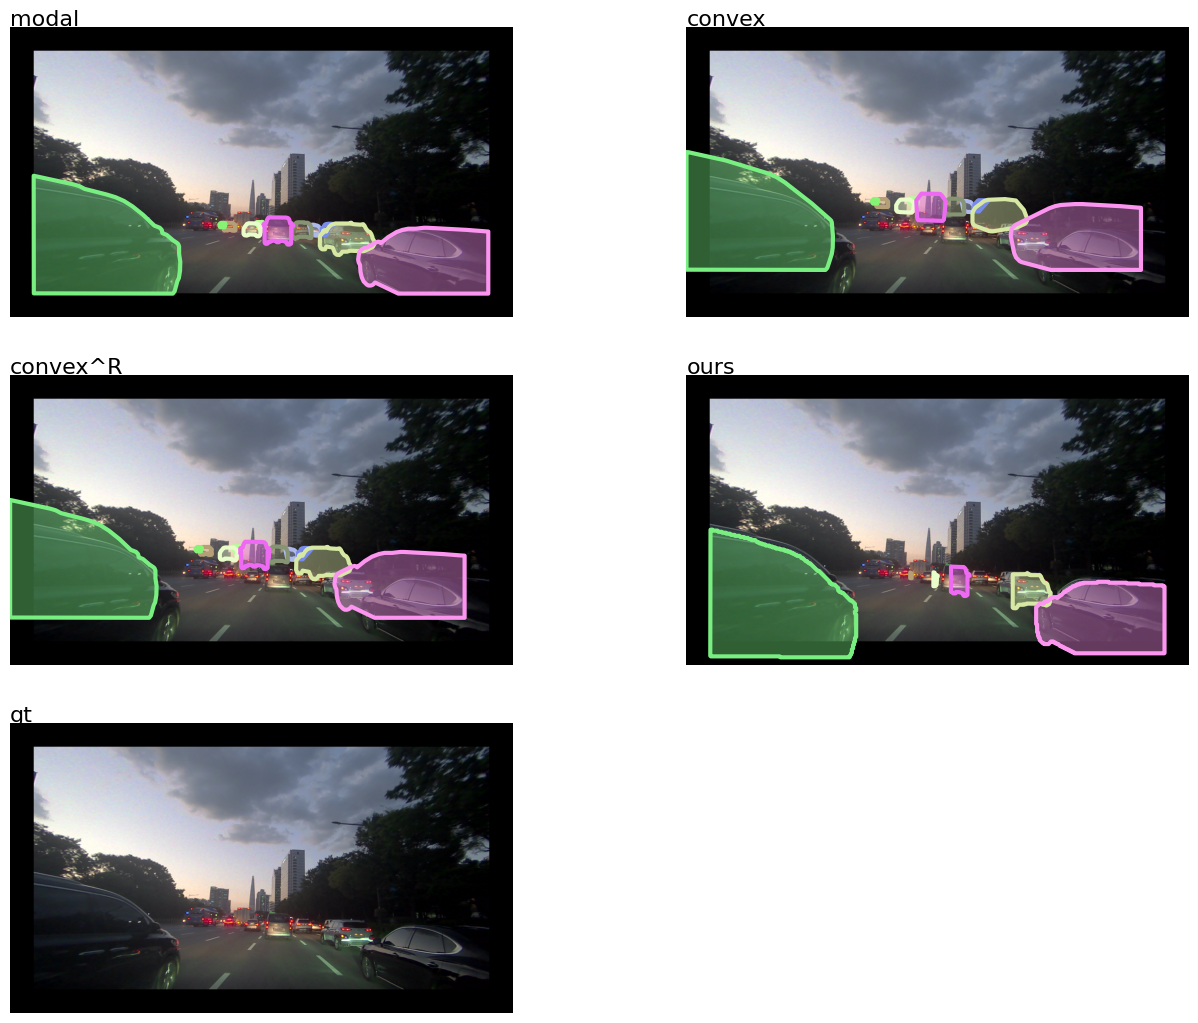

In [20]:
# show amodal
exclude = []
rows = 3
cols = 2
bbox_show = [0, 0, 500, height]
bbox_show = None

selidx = np.array([i for i in np.arange(modal.shape[0]) if i not in exclude])
image_show = padded_image[bbox_show[1]:bbox_show[3], bbox_show[0]:bbox_show[2], :] \
    if bbox_show is not None else padded_image.copy()

if bbox_show is not None:
    plt.figure(figsize=(16, 16./(bbox_show[2]-bbox_show[0])*(bbox_show[3]-bbox_show[1]) * 3 / 2))
else:
    plt.figure(figsize=(16, 16./width*height * rows / cols))
    
toshow = [resized_modal, amodal_pred_cvx, amodal_pred_cvxr, amodal_pred_ours, amodal_gt]
title = ['modal', 'convex', 'convex^R', 'ours', 'gt']

colors = [(np.random.random((1, 3)) * 0.6 + 0.4).tolist()[0] for i in range(len(selidx))]
for i in range(len(toshow)):
    plt.subplot(rows, cols, i + 1)
    ax = plt.gca()
    plt.imshow(image_show)
    plt.axis('off')
    plt.text(0, -10, title[i])
    pface, pedge = polygon_drawing(toshow[i], selidx, colors, bbox_show, thickness=3)
    ax.add_collection(pface)
    ax.add_collection(pedge)

# plt.savefig('outputs/amodal_display/kins_{}.jpg'.format(img_idx), dpi=72)
# cv2.imwrite("outputs/amodal_display/kins_{}_img.jpg".format(img_idx),
#             image_resize(image_sub[:,:,::-1], long_size=480))
plt.show()

In [22]:
# content completion

show_idx = 25 # set to -1 to show the background

fg_idx = list(range(modal.shape[0]))
input_size = 256
input_size_bkg = 384
fg_dilate = int(float(input_size) / 256 * 5)
bg_dilate = int(float(input_size_bkg) / 256 * 3)

# for objects
rgb_decomps = []
mask_decomps = []
compose = lambda image, alpha: np.concatenate([image, alpha[:,:,np.newaxis]], axis=2)
for i in fg_idx:
    ret, vsb_mask = content_completion(pcnetc, image, input_size, modal, bboxes, amodal_patches_pred, category, i, fg_dilate, False)
    trimap = gettrimap(amodal_pred_ours[i], 3)
    alpha = matting_model.inference(ret, trimap)
    ret = compose(ret, alpha)
    rgb_decomps.append(ret)

# background inpainting
bkg, vsb_mask = bkg_inpaint(inpaintnet, image, input_size_bkg, modal, fg_idx, bg_dilate)

for c in range(3):
    bkg[:,:,c][vsb_mask == 1] = image[:,:,c][vsb_mask == 1]

# show
plt.figure(figsize=(15, 30./img.width*img.height))
ax = plt.subplot(211)
plt.imshow(image)
plt.axis('off')
plt.subplot(212)
if show_idx == -1:
    plt.imshow(bkg)
else:
    this_obj = rgb_decomps[fg_idx.index(show_idx)]
    plt.imshow(this_obj)
plt.axis('off')
plt.show()

# save
if False:
    sort_ind = topological_sort(order_matrix)
    if not os.path.isdir('outputs/decomposition/image_{:04d}'.format(img_idx)):
        os.makedirs('outputs/decomposition/image_{:04d}'.format(img_idx))
    cv2.imwrite('outputs/decomposition/image_{:04d}.png'.format(img_idx), image[:,:,::-1])
    for i in sort_ind:
        obj = rgb_decomps[i]
        rgb = obj[:,:,:3]
        alpha = obj[:,:,3:]
        cv2.imwrite('outputs/decomposition/image_{:04d}/obj_{:03d}.png'.format(
            img_idx, i), np.concatenate([rgb[:,:,::-1], alpha], axis=2))
    cv2.imwrite('outputs/decomposition/image_{:04d}/bkg.png'.format(img_idx), bkg[:,:,::-1])

Exception: matting trimap failed.